📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807

📊 Análisis inicial de datos:
--------------------------------------------------
Tipos de datos:
float64    417
int64      199
object       5
Name: count, dtype: int64

Valores nulos por columna:
7858

Estadísticas básicas de columnas numéricas:
         logBB     LogP    nAcid    nBase  nAromAtom  nAromBond    nAtom  \
count  1058.00  7807.00  7807.00  7807.00    7807.00    7807.00  7807.00   
mean     -0.08     2.36     0.21     0.68       7.44       7.57    52.15   
std       0.75     2.20     0.59     0.93       5.95       6.11    24.67   
min      -2.69    -8.90     0.00     0.00       0.00       0.00     1.00   
25%      -0.54     1.20     0.00     0.00       0.00       0.00    38.00   
50%      -0.02     2.55     0.00     1.00       6.00       6.00    49.00   
75%       0.42     3.79     0.00     1.00      12.00      12.00    60.00   
ma

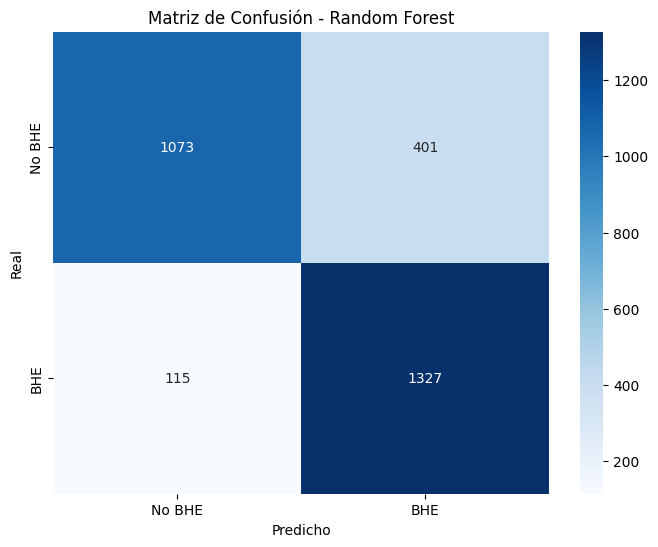

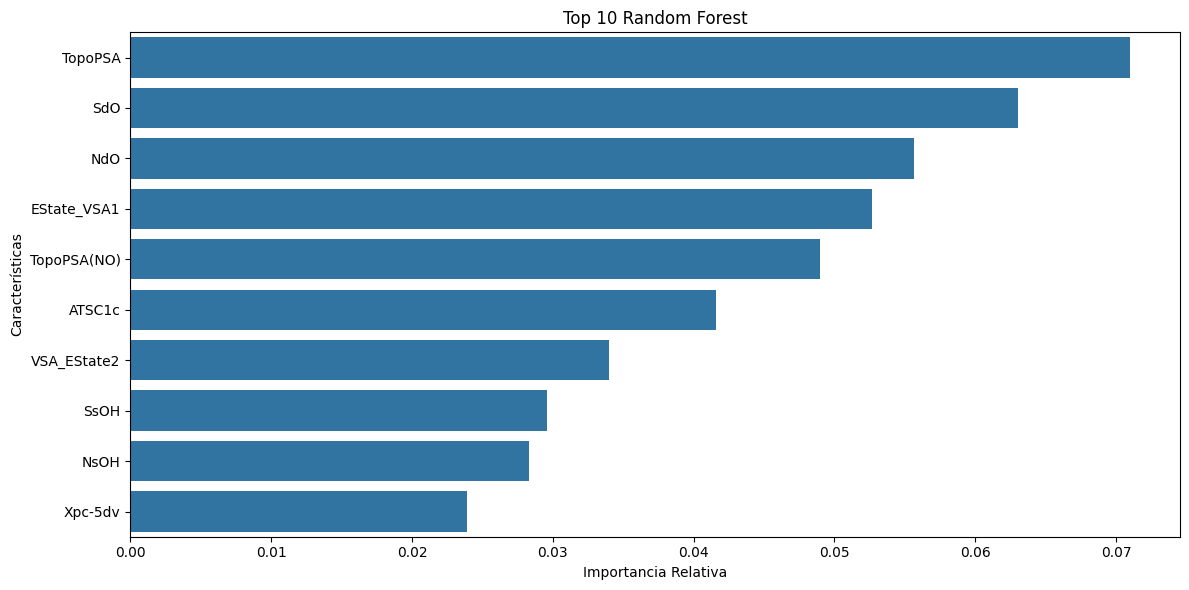


✨ Modelo Random Forest guardado como 'random_forest_model.joblib' ✨


In [2]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        
        self._analizar_datos_iniciales()
        print("✅ Preprocesamiento inicial completado")
    
    def _analizar_datos_iniciales(self):
        """Análisis inicial de los datos"""
        print("\n📊 Análisis inicial de datos:")
        print("-" * 50)
        print("Tipos de datos:")
        print(self.df.dtypes.value_counts())
        print("\nValores nulos por columna:")
        print(self.df.isnull().sum().sum())
        
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        print("\nEstadísticas básicas de columnas numéricas:")
        print(self.df[numeric_cols].describe().round(2))

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        """Visualización de importancia de características"""
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            return importances
        else:
            print("⚠️ Este modelo no proporciona importancia de características")
            return None

    def cross_validate_model(self, model, X, y, n_splits=5):
        """Validación cruzada del modelo"""
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        """Reporte de clasificación formateado"""
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        """Visualización de matriz de confusión"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        """Preparación de datos para entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        """Entrenamiento y evaluación del Random Forest"""
        # Preparar datos
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Definir modelo
        rf_model = RandomForestClassifier(
            n_estimators=50,
            max_depth=3,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42
        )
        
        # Validación cruzada
        cv_results = self.cross_validate_model(rf_model, pd.DataFrame(X_train), pd.Series(y_train))
        
        # Entrenamiento final
        rf_model.fit(X_train, y_train)
        
        # Predicciones
        y_pred = rf_model.predict(X_test)
        
        # Evaluación
        self.print_classification_report(y_test, y_pred, "Random Forest")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest")
        self.plot_feature_importance(rf_model, X_train.columns, "Random Forest")
        
        return rf_model, (X_test, y_test, y_pred)

# Ejecutar análisis
if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()
    
    # Guardar modelo
    joblib.dump(rf_model, 'random_forest_model.joblib')
    print("\n✨ Modelo Random Forest guardado como 'random_forest_model.joblib' ✨")

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807

📊 Análisis inicial de datos:
--------------------------------------------------
Tipos de datos:
float64    417
int64      199
object       5
Name: count, dtype: int64

Valores nulos por columna:
7858

Estadísticas básicas de columnas numéricas:
         logBB     LogP    nAcid    nBase  nAromAtom  nAromBond    nAtom  \
count  1058.00  7807.00  7807.00  7807.00    7807.00    7807.00  7807.00   
mean     -0.08     2.36     0.21     0.68       7.44       7.57    52.15   
std       0.75     2.20     0.59     0.93       5.95       6.11    24.67   
min      -2.69    -8.90     0.00     0.00       0.00       0.00     1.00   
25%      -0.54     1.20     0.00     0.00       0.00       0.00    38.00   
50%      -0.02     2.55     0.00     1.00       6.00       6.00    49.00   
75%       0.42     3.79     0.00     1.00      12.00      12.00    60.00   
ma

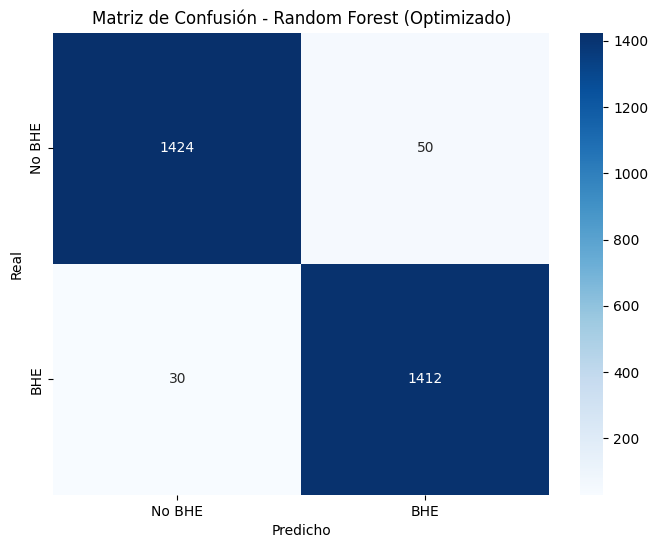

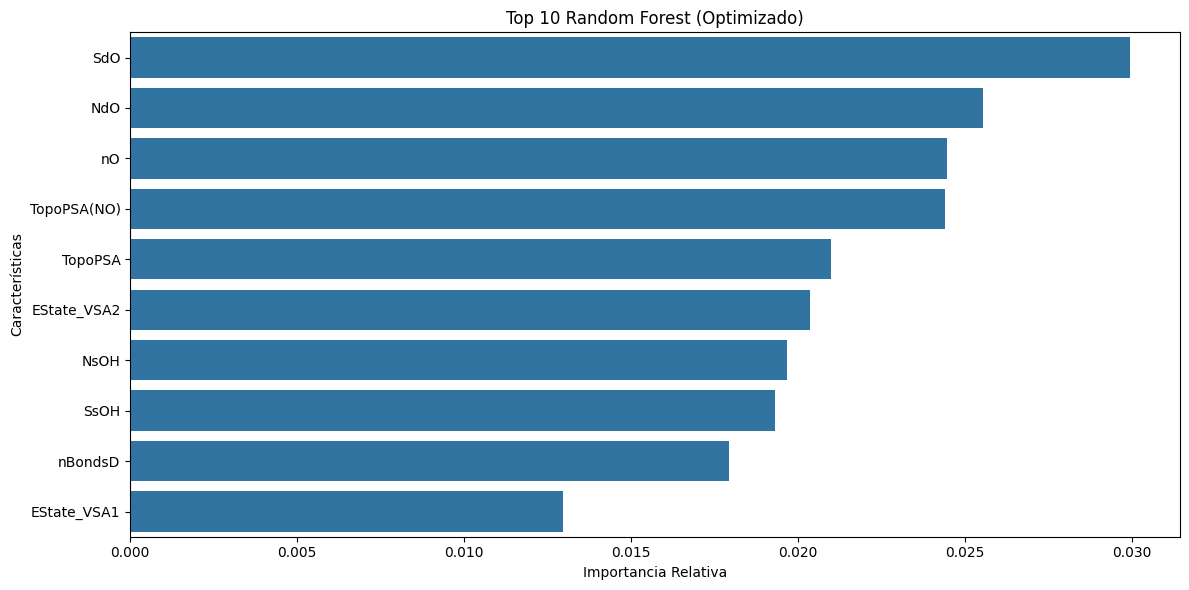


✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨


In [3]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        
        self._analizar_datos_iniciales()
        print("✅ Preprocesamiento inicial completado")
    
    def _analizar_datos_iniciales(self):
        """Análisis inicial de los datos"""
        print("\n📊 Análisis inicial de datos:")
        print("-" * 50)
        print("Tipos de datos:")
        print(self.df.dtypes.value_counts())
        print("\nValores nulos por columna:")
        print(self.df.isnull().sum().sum())
        
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        print("\nEstadísticas básicas de columnas numéricas:")
        print(self.df[numeric_cols].describe().round(2))

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        # Definir espacio de búsqueda
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(3, 11)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
        # Modelo base
        rf = RandomForestClassifier(random_state=42)
        
        # Configurar búsqueda aleatoria
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,  # Número de combinaciones a probar
            cv=3,       # Número de folds
            scoring='f1',
            n_jobs=-1,  # Usar todos los núcleos
            verbose=1,
            random_state=42
        )
        
        # Realizar búsqueda
        random_search.fit(X_train, y_train)
        
        # Guardar mejores parámetros
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        """Visualización de importancia de características"""
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            return importances
        else:
            print("⚠️ Este modelo no proporciona importancia de características")
            return None

    def cross_validate_model(self, model, X, y, n_splits=5):
        """Validación cruzada del modelo"""
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        """Reporte de clasificación formateado"""
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        """Visualización de matriz de confusión"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        """Preparación de datos para entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        """Entrenamiento y evaluación del Random Forest con optimización"""
        # Preparar datos
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Optimizar hiperparámetros
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        # Validación cruzada con el mejor modelo
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        # Predicciones finales
        y_pred = self.best_model.predict(X_test)
        
        # Evaluación
        self.print_classification_report(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_feature_importance(self.best_model, X_train.columns, "Random Forest (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

# Ejecutar análisis
if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()
    
    # Guardar modelo
    joblib.dump(rf_model, 'random_forest_model_optimized.joblib')
    print("\n✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨")

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis...

📊 Variables incluidas en el análisis:
--------------------------------------------------
Total de variables: 615

Listado de variables:
1. LogP
2. nAcid
3. nBase
4. nAromAtom
5. nAromBond
6. nAtom
7. nHeavyAtom
8. nSpiro
9. nBridgehead
10. nHetero
11. nH
12. nB
13. nC
14. nN
15. nO
16. nS
17. nP
18. nF
19. nCl
20. nBr
21. nI
22. nX
23. ATS0dv
24. ATS1dv
25. ATS2dv
26. ATS3dv
27. ATS4dv
28. ATS5dv
29. ATS6dv
30. ATS7dv
31. ATS8dv
32. ATS0d
33. ATS1d
34. ATS2d
35. ATS3d
36. ATS4d
37. ATS5d
38. ATS6d
39. ATS7d
40. ATS8d
41. ATS0Z
42. ATS1Z
43. ATS2Z
44. ATS3Z
45. ATS4Z
46. ATS5Z
47. ATS6Z
48. ATS7Z
49. ATS8Z
50. ATS0m
51. ATS1m
52. ATS2m
53. ATS3m
54. ATS4m
55. ATS5m
56. ATS6m
57. ATS7m
58. ATS8m
59. ATS0v
60. ATS1v
61. ATS2v
62. ATS3v
63. ATS4v
64. ATS5v
65. ATS6v
66. ATS7v
67. ATS8v
68. ATS0se
69. ATS1se
70. ATS2se
71. ATS3se
72. ATS4se
73. ATS5se
74. ATS6se
75. ATS7se
76. ATS8se
77. A

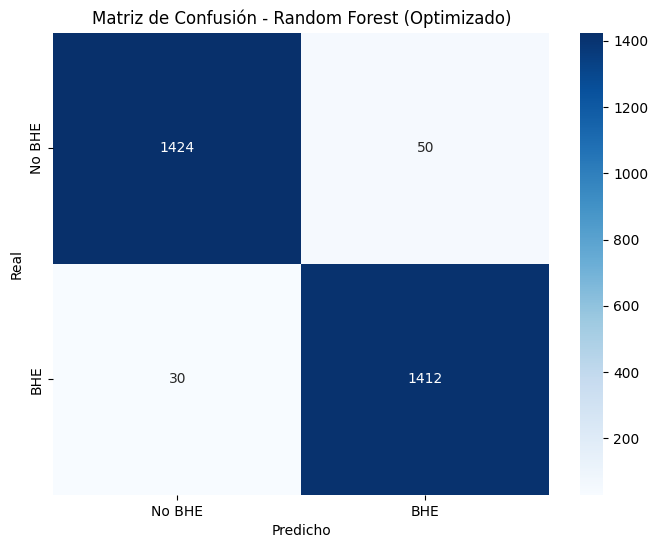

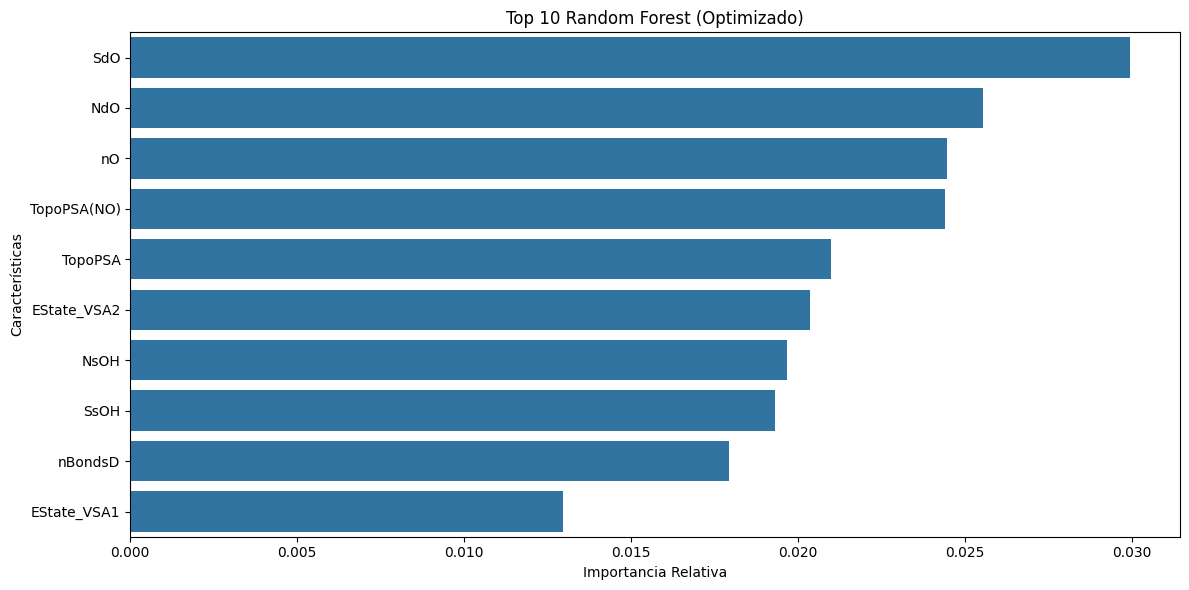


Top 10 características más importantes:
SdO: 0.0299
NdO: 0.0255
nO: 0.0244
TopoPSA(NO): 0.0244
TopoPSA: 0.0210
EState_VSA2: 0.0204
NsOH: 0.0197
SsOH: 0.0193
nBondsD: 0.0179
EState_VSA1: 0.0130

✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨


In [4]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis...")
        
        # Mostrar variables disponibles
        self.mostrar_variables()
    
    def mostrar_variables(self):
        """Mostrar información sobre las variables analizadas"""
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features
        
        print("\n📊 Variables incluidas en el análisis:")
        print("-" * 50)
        print(f"Total de variables: {len(features)}")
        print("\nListado de variables:")
        for i, feature in enumerate(features, 1):
            print(f"{i}. {feature}")

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(3, 11)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 características más importantes:")
            for i, row in importances.head(10).iterrows():
                print(f"{row['feature']}: {row['importance']:.4f}")
            
            return importances
        return None

    def cross_validate_model(self, model, X, y, n_splits=5):
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        y_pred = self.best_model.predict(X_test)
        
        self.print_classification_report(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_feature_importance(self.best_model, X_train.columns, "Random Forest (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()
    
    joblib.dump(rf_model, 'random_forest_model_optimized.joblib')
    print("\n✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨")

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis...

📊 Variables incluidas en el análisis:
--------------------------------------------------
Total de descriptores moleculares a analizar: 615

🔄 Preparando datos...

🔍 Optimizando hiperparámetros...

🔄 Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✨ Mejores parámetros encontrados:
bootstrap: False
class_weight: None
max_depth: None
max_features: sqrt
min_samples_leaf: 7
min_samples_split: 15
n_estimators: 152

Mejor score F1: 0.962

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.966
Precision: 0.965
Recall: 0.969
F1-score: 0.967

Fold 2 resultados:
Accuracy: 0.962
Precision: 0.952
Recall: 0.971
F1-score: 0.961

Fold 3 resultados:
Accuracy: 0.976
Precision: 0.973
Recall: 0.980
F1-score: 0.976

Fold 4 resultados:
Accuracy: 0.963
Precision: 0.951
Recall: 0.977
F1-score: 0.964

Fold 5 resultados:
Accuracy: 0.965
Pre

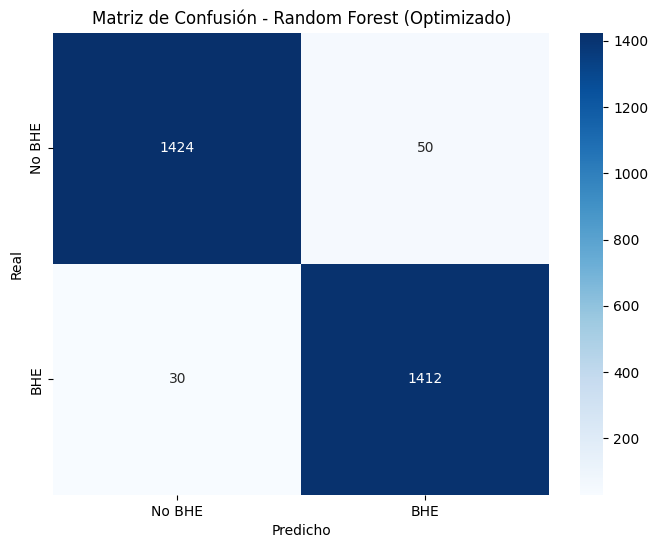

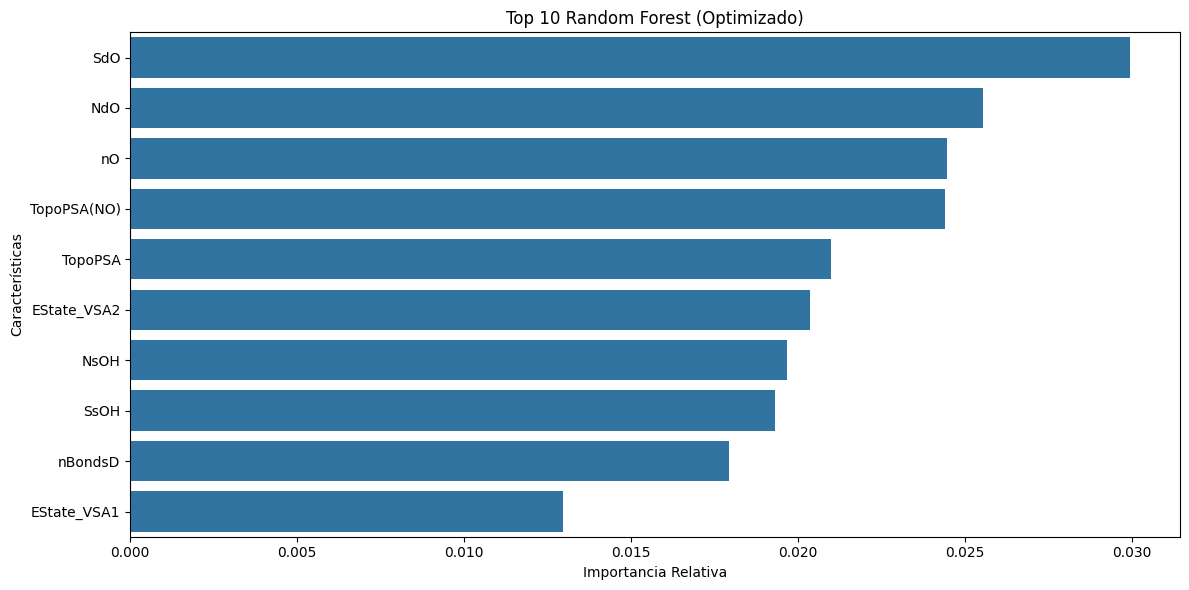


Top 10 características más importantes:
SdO: 0.0299
NdO: 0.0255
nO: 0.0244
TopoPSA(NO): 0.0244
TopoPSA: 0.0210
EState_VSA2: 0.0204
NsOH: 0.0197
SsOH: 0.0193
nBondsD: 0.0179
EState_VSA1: 0.0130


In [6]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis...")
        
        # Mostrar variables disponibles
        self.mostrar_variables()
    
    def mostrar_variables(self):
        """Mostrar información sobre las variables analizadas"""
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features

        print("\n📊 Variables incluidas en el análisis:")
        print("-" * 50)
        print(f"Total de descriptores moleculares a analizar: {len(features)}")

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(3, 11)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 características más importantes:")
            for i, row in importances.head(10).iterrows():
                print(f"{row['feature']}: {row['importance']:.4f}")
            
            return importances
        return None

    def cross_validate_model(self, model, X, y, n_splits=5):
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        y_pred = self.best_model.predict(X_test)
        
        self.print_classification_report(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_feature_importance(self.best_model, X_train.columns, "Random Forest (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()


📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis...

📊 Total de descriptores a analizar: 615

🔄 Preparando datos...

🔍 Optimizando hiperparámetros...

🔄 Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✨ Mejores parámetros encontrados:
bootstrap: False
class_weight: None
max_depth: None
max_features: sqrt
min_samples_leaf: 7
min_samples_split: 15
n_estimators: 152

Mejor score F1: 0.962

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.966
Precision: 0.965
Recall: 0.969
F1-score: 0.967

Fold 2 resultados:
Accuracy: 0.962
Precision: 0.952
Recall: 0.971
F1-score: 0.961

Fold 3 resultados:
Accuracy: 0.976
Precision: 0.973
Recall: 0.980
F1-score: 0.976

Fold 4 resultados:
Accuracy: 0.963
Precision: 0.951
Recall: 0.977
F1-score: 0.964

Fold 5 resultados:
Accuracy: 0.965
Precision: 0.960
Recall: 0.972
F1-score: 0.966

=== REPORTE DE CLASIFICACIÓN - Random Forest (Optimiza

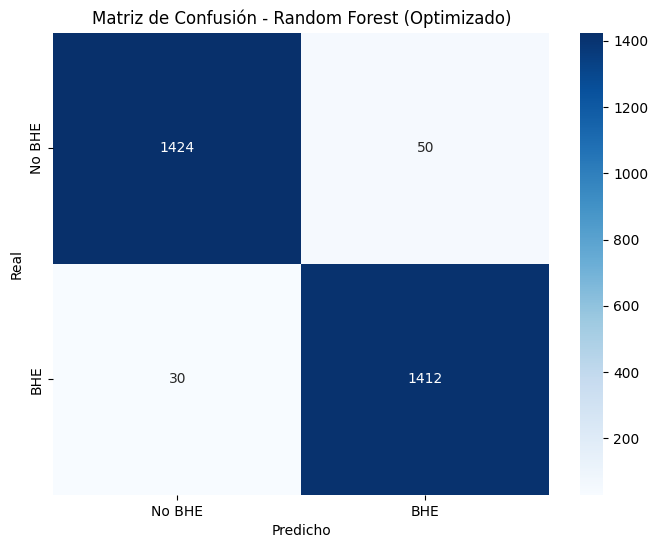

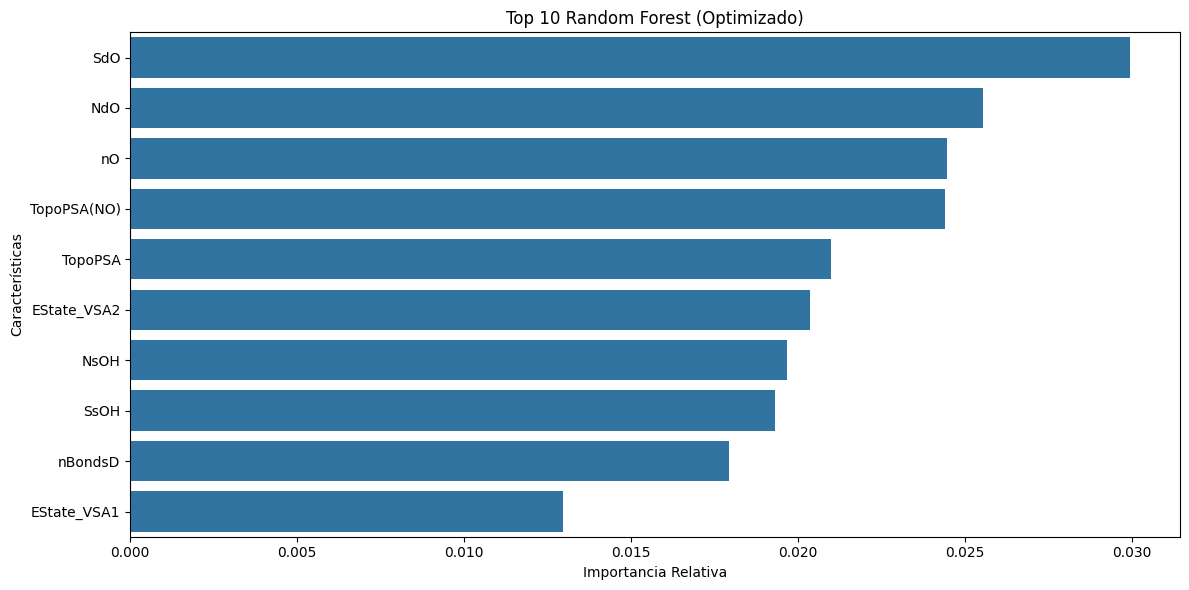


Top 10 características más importantes:
SdO: 0.0299
NdO: 0.0255
nO: 0.0244
TopoPSA(NO): 0.0244
TopoPSA: 0.0210
EState_VSA2: 0.0204
NsOH: 0.0197
SsOH: 0.0193
nBondsD: 0.0179
EState_VSA1: 0.0130


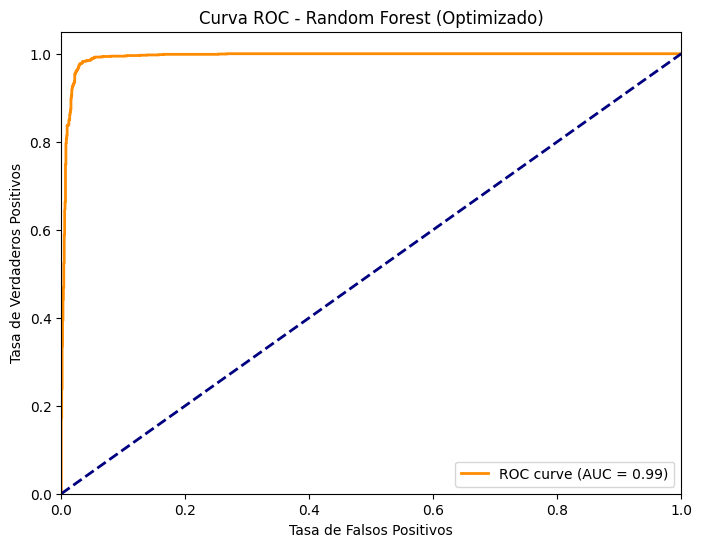


✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨


In [8]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis...")
        self.show_feature_count()
    
    def show_feature_count(self):
        """Mostrar cantidad de descriptores"""
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features
        print(f"\n📊 Total de descriptores a analizar: {len(features)}")

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(3, 11)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 características más importantes:")
            for i, row in importances.head(10).iterrows():
                print(f"{row['feature']}: {row['importance']:.4f}")
            
            return importances
        return None

    def plot_roc_curve(self, y_test, y_prob, title="Curva ROC"):
        """Visualizar curva ROC"""
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    def cross_validate_model(self, model, X, y, n_splits=5):
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        self.print_classification_report(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_feature_importance(self.best_model, X_train.columns, "Random Forest (Optimizado)")
        self.plot_roc_curve(y_test, y_prob, "Curva ROC - Random Forest (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()
    
    joblib.dump(rf_model, 'random_forest_model_optimized.joblib')
    print("\n✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨")

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis...

📊 Total de descriptores a analizar: 615

🔄 Preparando datos...

🔍 Optimizando hiperparámetros...

🔄 Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✨ Mejores parámetros encontrados:
bootstrap: True
class_weight: balanced
max_depth: 6
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 16
n_estimators: 107

Mejor score F1: 0.889

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.880
Precision: 0.832
Recall: 0.956
F1-score: 0.890

Fold 2 resultados:
Accuracy: 0.868
Precision: 0.805
Recall: 0.969
F1-score: 0.879

Fold 3 resultados:
Accuracy: 0.878
Precision: 0.824
Recall: 0.963
F1-score: 0.888

Fold 4 resultados:
Accuracy: 0.871
Precision: 0.813
Recall: 0.965
F1-score: 0.883

Fold 5 resultados:
Accuracy: 0.880
Precision: 0.817
Recall: 0.975
F1-score: 0.889

=== REPORTE DE CLASIFICACIÓN - Random Forest (Optimiza

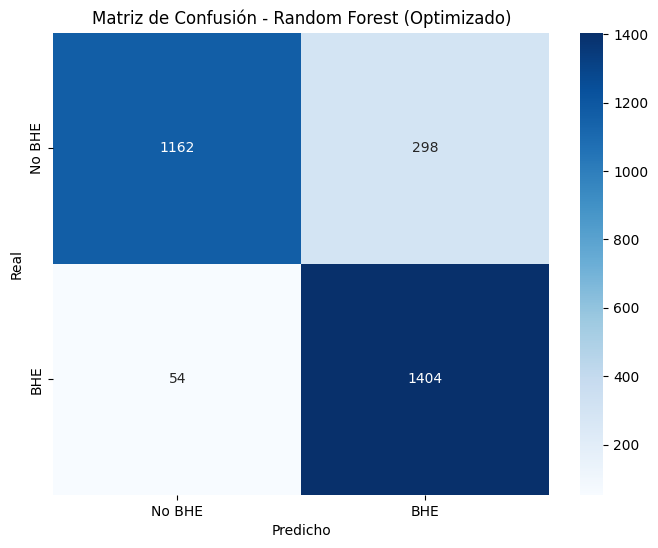

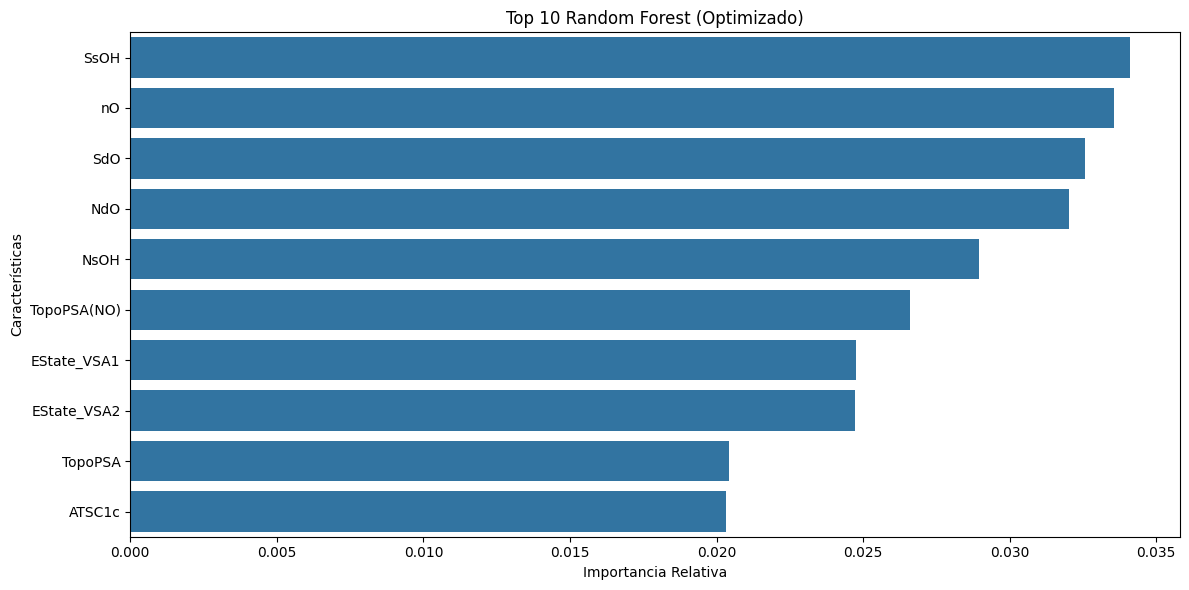


Top 10 características más importantes:
SsOH: 0.0341
nO: 0.0335
SdO: 0.0326
NdO: 0.0320
NsOH: 0.0289
TopoPSA(NO): 0.0266
EState_VSA1: 0.0248
EState_VSA2: 0.0247
TopoPSA: 0.0204
ATSC1c: 0.0203


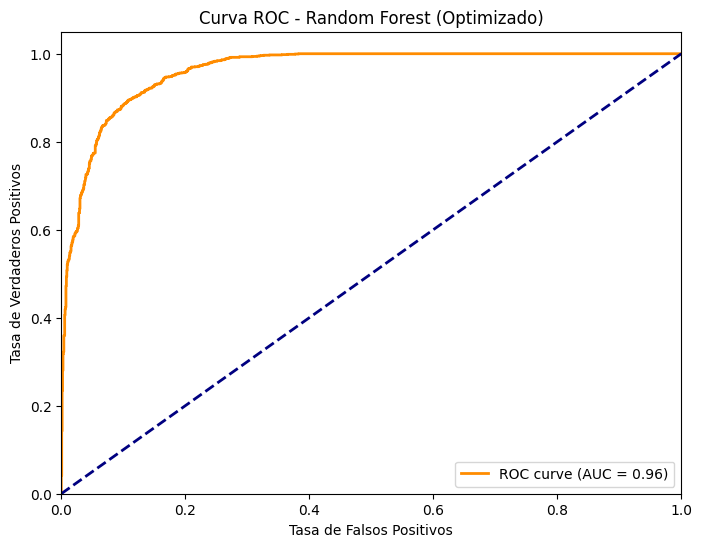


✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨


In [9]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
import plotly.graph_objects as go
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis...")
        self.show_feature_count()
    
    def show_feature_count(self):
        """Mostrar cantidad de descriptores"""
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features
        print(f"\n📊 Total de descriptores a analizar: {len(features)}")

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        param_dist = {
            'n_estimators': randint(50, 150),        # Reducido
            'max_depth': [3, 4, 5, 6],               # Limitado
            'min_samples_split': randint(5, 20),     # Aumentado
            'min_samples_leaf': randint(4, 10),      # Aumentado
            'max_features': ['sqrt', 'log2'],        # Limitado
            'bootstrap': [True],
            'class_weight': ['balanced']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=15,
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 características más importantes:")
            for i, row in importances.head(10).iterrows():
                print(f"{row['feature']}: {row['importance']:.4f}")
            
            return importances
        return None

    def plot_roc_curve(self, y_test, y_prob, title="Curva ROC"):
        """Visualizar curva ROC"""
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    def cross_validate_model(self, model, X, y, n_splits=5):
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        # Cambio de SMOTE a ADASYN
        adasyn = ADASYN(
            random_state=42,
            n_neighbors=5,      # Número de vecinos para generar muestras
            sampling_strategy='auto'  # Balancear automáticamente las clases
        )
        X_res, y_res = adasyn.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_random_forest(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        self.print_classification_report(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "Random Forest (Optimizado)")
        self.plot_feature_importance(self.best_model, X_train.columns, "Random Forest (Optimizado)")
        self.plot_roc_curve(y_test, y_prob, "Curva ROC - Random Forest (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    rf_model, (X_test, y_test, y_pred) = modelo_bhe.train_random_forest()
    
    joblib.dump(rf_model, 'random_forest_model_optimized.joblib')
    print("\n✨ Modelo Random Forest optimizado guardado como 'random_forest_model_optimized.joblib' ✨")

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis...

📊 Total de descriptores a analizar: 615

🔄 Preparando datos...

🔍 Optimizando hiperparámetros...

🔄 Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✨ Mejores parámetros encontrados:
C: 8.699404067363206
class_weight: balanced
gamma: 0.008851590032994294
kernel: rbf
probability: True

Mejor score F1: 0.974

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.976
Precision: 0.959
Recall: 0.995
F1-score: 0.977

Fold 2 resultados:
Accuracy: 0.965
Precision: 0.942
Recall: 0.991
F1-score: 0.966

Fold 3 resultados:
Accuracy: 0.970
Precision: 0.949
Recall: 0.994
F1-score: 0.971

Fold 4 resultados:
Accuracy: 0.970
Precision: 0.946
Recall: 0.997
F1-score: 0.971

Fold 5 resultados:
Accuracy: 0.973
Precision: 0.953
Recall: 0.994
F1-score: 0.973

=== REPORTE DE CLASIFICACIÓN - SVM (Optimizado) ===

Resultados por Clase:
--------

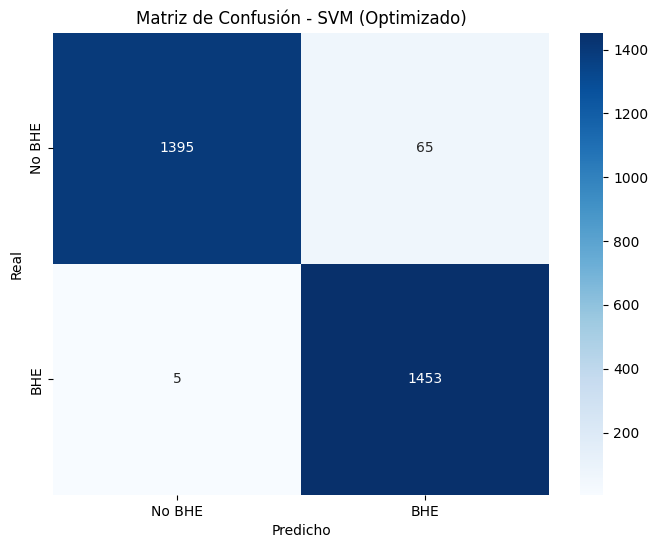

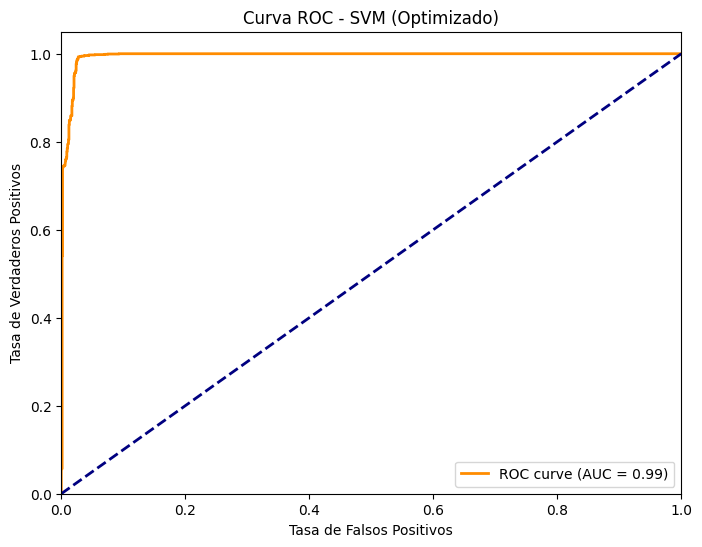


✨ Modelo SVM optimizado guardado como 'svm_model_optimized.joblib' ✨


In [10]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
import plotly.graph_objects as go
from scipy.stats import uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_params = None
        self.best_model = None
        
        print("\n🔍 Iniciando análisis...")
        self.show_feature_count()
    
    def show_feature_count(self):
        """Mostrar cantidad de descriptores"""
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features
        print(f"\n📊 Total de descriptores a analizar: {len(features)}")

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros usando RandomizedSearchCV"""
        print("\n🔄 Iniciando búsqueda de hiperparámetros...")
        
        # Parámetros específicos para SVM
        param_dist = {
            'C': uniform(0.1, 10.0),           # Factor de regularización
            'kernel': ['rbf', 'linear'],       # Kernel a utilizar
            'gamma': ['scale', 'auto'] + list(uniform(0.001, 0.1).rvs(5)),
            'class_weight': ['balanced'],      # Peso de clases
            'probability': [True]              # Necesario para ROC
        }
        
        # Modelo base SVM
        svm = SVC(random_state=42)
        
        # Búsqueda aleatoria
        random_search = RandomizedSearchCV(
            estimator=svm,
            param_distributions=param_dist,
            n_iter=15,
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        
        print("\n✨ Mejores parámetros encontrados:")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
            
        print(f"\nMejor score F1: {random_search.best_score_:.3f}")
        
        return self.best_model

    def plot_roc_curve(self, y_test, y_prob, title="Curva ROC"):
        """Visualizar curva ROC"""
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    def cross_validate_model(self, model, X, y, n_splits=5):
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def prepare_data(self):
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        adasyn = ADASYN(
            random_state=42,
            n_neighbors=5,
            sampling_strategy='auto'
        )
        X_res, y_res = adasyn.fit_resample(X_scaled, y)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def train_svm(self):
        """Entrenamiento y evaluación del modelo SVM"""
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        print("\n🔍 Optimizando hiperparámetros...")
        self.optimize_hyperparameters(X_train, y_train)
        
        cv_results = self.cross_validate_model(
            self.best_model, 
            pd.DataFrame(X_train), 
            pd.Series(y_train)
        )
        
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        self.print_classification_report(y_test, y_pred, "SVM (Optimizado)")
        self.plot_confusion_matrix(y_test, y_pred, "SVM (Optimizado)")
        self.plot_roc_curve(y_test, y_prob, "Curva ROC - SVM (Optimizado)")
        
        return self.best_model, (X_test, y_test, y_pred)

if __name__ == "__main__":
    modelo_bhe = PreparacionBHE(df)
    svm_model, (X_test, y_test, y_pred) = modelo_bhe.train_svm()
    
    joblib.dump(svm_model, 'svm_model_optimized.joblib')
    print("\n✨ Modelo SVM optimizado guardado como 'svm_model_optimized.joblib' ✨")

In [27]:
from rdkit import Chem
from rdkit.Chem import QED
import pandas as pd

def calculate_qed(smiles):
    """
    Calcula el valor de QED para una molécula dada su representación SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return QED.qed(mol)  # Usar el método de QED para calcular el valor
    else:
        return None  # Si no se puede generar la molécula, retornar None

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

# Asegúrate de que la columna de SMILES existe
if 'SMILES' in df.columns:
    # Calcular QED para cada molécula y añadirlo al DataFrame
    df['QED'] = df['SMILES'].apply(calculate_qed)
else:
    print("❌ La columna 'SMILES' no se encontró en el DataFrame.")

# Mostrar las primeras filas del DataFrame con el nuevo descriptor QED
print("👀 Primeras filas del DataFrame con QED:")
print(df[['SMILES', 'QED']].head())

# Resumen estadístico incluyendo QED
print("\n📊 Resumen estadístico incluyendo QED:")
print(df.describe())


👀 Primeras filas del DataFrame con QED:
                          SMILES       QED
0                      BrC(Br)Br  0.581278
1    Brc1c(NC2=NCCN2)ccc2nccnc12  0.840528
2  Brc1cc(Br)c(NC2=NCCN2)c(Br)c1  0.762103
3        Brc1cccc(Br)c1NC1=NCCN1  0.834727
4                              C  0.359785

📊 Resumen estadístico incluyendo QED:
             logBB         LogP        nAcid        nBase    nAromAtom  \
count  1058.000000  7807.000000  7807.000000  7807.000000  7807.000000   
mean     -0.077873     2.356028     0.214935     0.677597     7.444345   
std       0.751623     2.195464     0.585430     0.929318     5.949501   
min      -2.690000    -8.895300     0.000000     0.000000     0.000000   
25%      -0.535000     1.202650     0.000000     0.000000     0.000000   
50%      -0.020000     2.547800     0.000000     1.000000     6.000000   
75%       0.420000     3.786400     0.000000     1.000000    12.000000   
max       1.700000    12.605800     8.000000    10.000000    44.000000 

In [33]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Cambia a RandomForestClassifier si es clasificación
from sklearn.metrics import mean_squared_error  # Cambia a accuracy_score si es clasificación
import joblib

def calculate_qed(smiles):
    """
    Calcula el valor de QED para una molécula dada su representación SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return QED.qed(mol)  # Usar el método de QED para calcular el valor
    else:
        return None  # Si no se puede generar la molécula, retornar None

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

# Asegúrate de que la columna de SMILES existe
if 'SMILES' in df.columns:
    # Calcular QED para cada molécula y añadirlo al DataFrame
    df['QED'] = df['SMILES'].apply(calculate_qed)
else:
    print("❌ La columna 'SMILES' no se encontró en el DataFrame.")

# Mostrar las primeras filas del DataFrame con el nuevo descriptor QED
print("👀 Primeras filas del DataFrame con QED:")
print(df[['SMILES', 'QED']].head())

# Resumen estadístico incluyendo QED
print("\n📊 Resumen estadístico incluyendo QED:")
print(df.describe())

# Crear una copia de la columna QED
df['QED_copy'] = df['QED']

# Seleccionar solo las columnas numéricas, excluyendo las categóricas
# Esto filtra columnas que son de tipo numérico y también verifica si hay valores nulos
X = df.select_dtypes(include=['number']).drop(columns=['QED_copy'])  # Excluye la columna objetivo

# Eliminar filas con valores nulos
X = X.dropna()
y = df['QED_copy'][X.index]  # Asegurarse de que y tenga el mismo índice que X

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo (Random Forest en este caso)
model = RandomForestRegressor(random_state=42)  # Cambia a RandomForestClassifier si es clasificación
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo (cambiar según el tipo de modelo)
mse = mean_squared_error(y_test, y_pred)
print(f"📝 Error cuadrático medio: {mse}")


👀 Primeras filas del DataFrame con QED:
                          SMILES       QED
0                      BrC(Br)Br  0.581278
1    Brc1c(NC2=NCCN2)ccc2nccnc12  0.840528
2  Brc1cc(Br)c(NC2=NCCN2)c(Br)c1  0.762103
3        Brc1cccc(Br)c1NC1=NCCN1  0.834727
4                              C  0.359785

📊 Resumen estadístico incluyendo QED:
             logBB         LogP        nAcid        nBase    nAromAtom  \
count  1058.000000  7807.000000  7807.000000  7807.000000  7807.000000   
mean     -0.077873     2.356028     0.214935     0.677597     7.444345   
std       0.751623     2.195464     0.585430     0.929318     5.949501   
min      -2.690000    -8.895300     0.000000     0.000000     0.000000   
25%      -0.535000     1.202650     0.000000     0.000000     0.000000   
50%      -0.020000     2.547800     0.000000     1.000000     6.000000   
75%       0.420000     3.786400     0.000000     1.000000    12.000000   
max       1.700000    12.605800     8.000000    10.000000    44.000000 

In [14]:
# Para las variables que usamos en QED
variables_importantes = ['MW', 'LogP', 'nHBAcc', 'nHBDon', 'TopoPSA', 'nRot', 'naRing', 'logBB']

print("Estadísticas descriptivas de variables principales:")
print(df[variables_importantes].describe())

# Distribución por clase
print("\nEstadísticas por clase BBB:")
print(df.groupby('BBB_Class')[variables_importantes].describe())

Estadísticas descriptivas de variables principales:
                MW         LogP       nHBAcc       nHBDon      TopoPSA  \
count  7807.000000  7807.000000  7807.000000  7807.000000  7807.000000   
mean    385.035739     2.356028     5.418343     2.009991    94.284592   
std     170.733951     2.195464     3.696355     2.262473    72.811498   
min       7.016005    -8.895300     0.000000     0.000000     0.000000   
25%     285.079568     1.202650     3.000000     1.000000    45.150000   
50%     362.103335     2.547800     4.000000     1.000000    74.600000   
75%     451.264213     3.786400     7.000000     3.000000   117.780000   
max    1881.070533    12.605800    33.000000    24.000000   662.410000   

              nRot       naRing        logBB  
count  7807.000000  7807.000000  1058.000000  
mean      4.770590     1.320225    -0.077873  
std       3.636474     1.080268     0.751623  
min       0.000000     0.000000    -2.690000  
25%       2.000000     0.000000    -0.535000  

Fold 1
Fold 1 accuracy: 0.9384
Fold 2
Fold 2 accuracy: 0.8983
Fold 3
Fold 3 accuracy: 0.8959
Fold 4
Fold 4 accuracy: 0.8975
Fold 5
Fold 5 accuracy: 0.8927
Mean CV accuracy: 0.9046 (+/- 0.0170)
Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8136 - loss: 0.7491 - val_accuracy: 0.9365 - val_loss: 0.3866 - learning_rate: 5.0000e-04
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9011 - loss: 0.4179 - val_accuracy: 0.9683 - val_loss: 0.3303 - learning_rate: 5.0000e-04
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9097 - loss: 0.3590 - val_accuracy: 0.9524 - val_loss: 0.3122 - learning_rate: 5.0000e-04
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9205 - loss: 0.3315 - val_accuracy: 0.9683 - val_loss: 0.2888 - learning_rate: 5.0000e-04
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9203 - loss: 0.3190 - val_accuracy: 0.9365 - val_loss: 0.2873 - learning_rate: 5.0000e-04
Epoch 6/200
97/97 ━━━━━━━━━

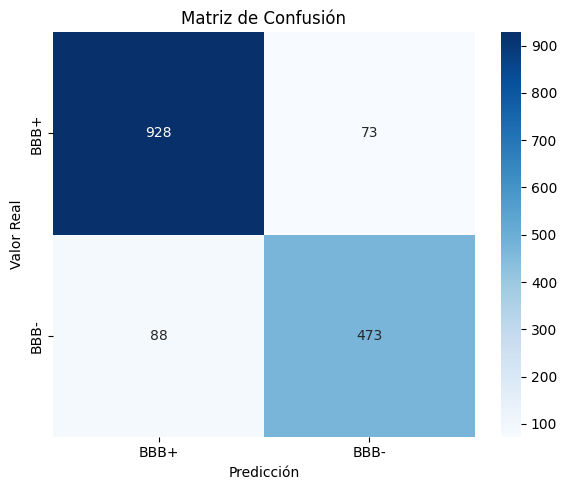


Informe de Clasificación:
              precision    recall  f1-score   support

        BBB+       0.91      0.93      0.92      1001
        BBB-       0.87      0.84      0.85       561

    accuracy                           0.90      1562
   macro avg       0.89      0.89      0.89      1562
weighted avg       0.90      0.90      0.90      1562



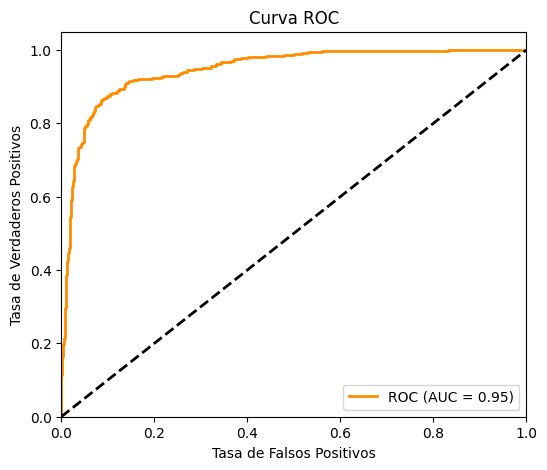

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns

"""
Carga y preprocesamiento de datos
"""
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

"""
Funciones de evaluación molecular
"""
def evaluate_smiles_length(smiles):
    length = len(smiles)
    if length <= 59: return 'BBB+'
    else: return 'BBB-'

def evaluate_chirality(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return 'Quiral' if len(chiral_centers) > 0 else 'No Quiral'

def evaluate_polarity(mol):
    logp = Descriptors.MolLogP(mol)
    if -4.38 <= logp <= 10.06: return 'BBB+'
    else: return 'BBB-'

def lipinski_rule(mol):
    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return sum([mw <= 500, logp <= 5, hbd <= 5, hba <= 10])

def classify_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return 'SMILES inválido'
    length_class = evaluate_smiles_length(smiles)
    polarity_class = evaluate_polarity(mol)
    lipinski_score = lipinski_rule(mol)
    if length_class == 'BBB+' and polarity_class == 'BBB+' and lipinski_score >= 3:
        return 'BBB+'
    else:
        return 'BBB-'

"""
Aplicación de clasificaciones
"""
df['BBB_Class'] = df['SMILES'].apply(classify_molecule)
df['Chirality'] = df['SMILES'].apply(lambda x: evaluate_chirality(Chem.MolFromSmiles(x)))
df['SMILES_Length'] = df['SMILES'].apply(len)
df['Lipinski_Score'] = df['SMILES'].apply(lambda x: lipinski_rule(Chem.MolFromSmiles(x)))

"""
Preparación de datos para CNN
"""
def smiles_to_fingerprint(smiles, size=7806):
    mol = Chem.MolFromSmiles(smiles)
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=size)) if mol else [0] * size

features = ['nHBAcc', 'nHBDon', 'MW', 'TopoPSA', 'LabuteASA', 'SMILES_Length', 'Lipinski_Score']
X_fp = np.array([smiles_to_fingerprint(smile) for smile in df['SMILES']])
X_features = df[features].values
X_combined = np.concatenate([X_fp, X_features], axis=1)

"""
Codificación de la variable objetivo
"""
df['BBB_Class_Numeric'] = df['BBB_Class'].map({
    'BBB+': 0, 
    'BBB-': 1
})
y = to_categorical(df['BBB_Class_Numeric'])

"""
División de datos
"""
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

"""
Escalado de características
"""
scaler = StandardScaler()
X_train[:, -len(features):] = scaler.fit_transform(X_train[:, -len(features):])
X_test[:, -len(features):] = scaler.transform(X_test[:, -len(features):])

"""
Reshape para CNN
"""
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

"""
Definición del modelo CNN
"""
def create_model(input_shape, filters=8, kernel_size=5, dense_units=16, dropout_rate=0.3, learning_rate=0.0005, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation='softmax')  # Cambiado a 2 clases
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

"""
Implementación de validación cruzada
"""
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f'Fold {fold}')
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = create_model(input_shape=(X_train_fold.shape[1], 1))
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200, batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores[1])
    print(f'Fold {fold} accuracy: {scores[1]:.4f}')

print(f'Mean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')

"""
Entrenamiento del modelo final
"""
final_model = create_model(input_shape=(X_train.shape[1], 1))
final_history = final_model.fit(
    X_train, y_train,
    epochs=200, batch_size=64, validation_split=0.01,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

"""
Evaluación del modelo
"""
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

"""
Visualización de resultados
"""
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BBB+', 'BBB-'], yticklabels=['BBB+', 'BBB-'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

print("\nInforme de Clasificación:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['BBB+', 'BBB-']))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test_classes, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


En este modelo de aprendizaje profundo, se desarrolló una red neuronal convolucional (CNN) para predecir la capacidad de las moléculas para atravesar la barrera hematoencefálica (BBB). La variable objetivo es binaria, clasificando las moléculas como BBB+ (capacidad de atravesar la barrera) o BBB- (incapacidad de atravesar la barrera).

El modelo integra dos tipos de características moleculares:

Fingerprints moleculares (reducidos mediante PCA)
Descriptores moleculares numéricos (excluyendo variables con valores nulos)
La arquitectura CNN consiste en:

Dos capas convolucionales con activación ReLU
Capas de MaxPooling para reducción dimensional
Dropout para prevenir sobreajuste
Regularización L2 para control de complejidad
Una capa densa final con activación softmax
El modelo se entrenó utilizando:

Validación cruzada de 5 pliegues
Early stopping para prevenir sobreajuste
Pesos de clase para manejar el desbalanceo
Optimizador Adam con tasa de aprendizaje adaptativa
La evaluación del modelo se realizó mediante matriz de confusión, métricas de clasificación y curva ROC, demostrando su capacidad para predecir efectivamente la permeabilidad BBB de nuevas moléculas.

Número total de descriptores originales: 618
Número de descriptores sin nulos: 617
Componentes PCA de fingerprints: 886
Componentes PCA de descriptores: 1
Dimensiones finales de datos: (7807, 887)
Fold 1


c:\Users\USUARIO\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 accuracy: 0.9199
Fold 2
Fold 2 accuracy: 0.8006
Fold 3
Fold 3 accuracy: 0.7718
Fold 4
Fold 4 accuracy: 0.8151
Fold 5
Fold 5 accuracy: 0.8022
Mean CV accuracy: 0.8219 (+/- 0.0510)
Epoch 1/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6740 - loss: 1.5775 - val_accuracy: 0.7766 - val_loss: 0.8548 - learning_rate: 5.0000e-04
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7751 - loss: 0.7921 - val_accuracy: 0.8239 - val_loss: 0.6672 - learning_rate: 5.0000e-04
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7960 - loss: 0.6501 - val_accuracy: 0.8551 - val_loss: 0.5745 - learning_rate: 5.0000e-04
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8279 - loss: 0.5641 - val_accuracy: 0.8623 - val_loss: 0.5081 - learning_rate: 5.0000e-04
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8370 - loss: 0.5364 - val_accuracy: 0.8663 - val_loss: 0.4576 - learning_rate: 5.0000e-04
Epoch 6/200
157/157 ━━━━━━━━━

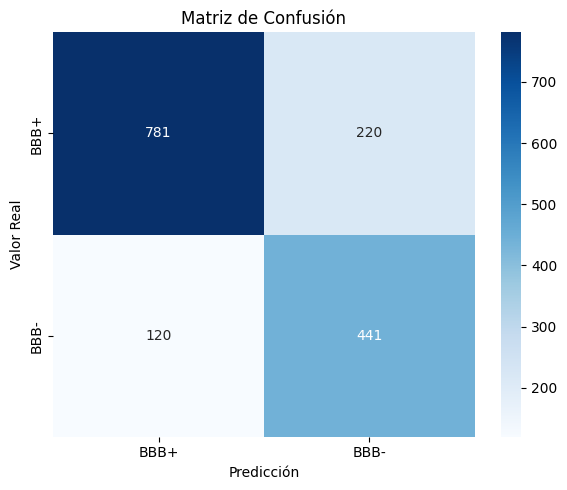


Informe de Clasificación:
              precision    recall  f1-score   support

        BBB+       0.87      0.78      0.82      1001
        BBB-       0.67      0.79      0.72       561

    accuracy                           0.78      1562
   macro avg       0.77      0.78      0.77      1562
weighted avg       0.80      0.78      0.79      1562



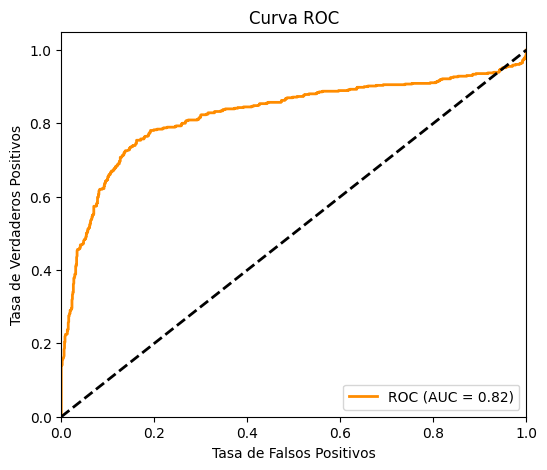

In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns

"""
Carga y preprocesamiento de datos
"""
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

"""
Funciones de evaluación molecular
"""
def evaluate_smiles_length(smiles):
    length = len(smiles)
    if length <= 59: return 'BBB+'
    else: return 'BBB-'

def evaluate_chirality(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return 'Quiral' if len(chiral_centers) > 0 else 'No Quiral'

def evaluate_polarity(mol):
    logp = Descriptors.MolLogP(mol)
    if -4.38 <= logp <= 10.06: return 'BBB+'
    else: return 'BBB-'

def lipinski_rule(mol):
    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return sum([mw <= 500, logp <= 5, hbd <= 5, hba <= 10])

def classify_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return 'SMILES inválido'
    length_class = evaluate_smiles_length(smiles)
    polarity_class = evaluate_polarity(mol)
    lipinski_score = lipinski_rule(mol)
    if length_class == 'BBB+' and polarity_class == 'BBB+' and lipinski_score >= 3:
        return 'BBB+'
    else:
        return 'BBB-'

"""
Aplicación de clasificaciones
"""
df['BBB_Class'] = df['SMILES'].apply(classify_molecule)
df['Chirality'] = df['SMILES'].apply(lambda x: evaluate_chirality(Chem.MolFromSmiles(x)))
df['SMILES_Length'] = df['SMILES'].apply(len)
df['Lipinski_Score'] = df['SMILES'].apply(lambda x: lipinski_rule(Chem.MolFromSmiles(x)))

"""
Preparación de datos para CNN y reducción de dimensionalidad
"""
# Obtener descriptores numéricos sin valores nulos
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
# Eliminar columnas con valores nulos
columns_without_null = df[numerical_features].columns[df[numerical_features].notna().all()]
print(f"Número total de descriptores originales: {len(numerical_features)}")
print(f"Número de descriptores sin nulos: {len(columns_without_null)}")

X_descriptors = df[columns_without_null].values

# Preparar fingerprints
def smiles_to_fingerprint(smiles, size=2048):
    mol = Chem.MolFromSmiles(smiles)
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=size)) if mol else [0] * size

# Generar fingerprints
X_fp = np.array([smiles_to_fingerprint(smile) for smile in df['SMILES']])

# Aplicar PCA a los fingerprints
pca_fp = PCA(n_components=0.95)
X_fp_reduced = pca_fp.fit_transform(X_fp)
print(f"Componentes PCA de fingerprints: {X_fp_reduced.shape[1]}")

# Aplicar PCA a los descriptores
pca_desc = PCA(n_components=0.95)
X_descriptors_reduced = pca_desc.fit_transform(X_descriptors)
print(f"Componentes PCA de descriptores: {X_descriptors_reduced.shape[1]}")

# Combinar características reducidas
X_combined = np.concatenate([X_fp_reduced, X_descriptors_reduced], axis=1)
print(f"Dimensiones finales de datos: {X_combined.shape}")

"""
Codificación de la variable objetivo
"""
df['BBB_Class_Numeric'] = df['BBB_Class'].map({
    'BBB+': 0, 
    'BBB-': 1
})
y = to_categorical(df['BBB_Class_Numeric'])

"""
División de datos y escalado
"""
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Calcular pesos de clase para manejar el desbalanceo
class_counts = np.sum(y_train, axis=0)
class_weights = dict(enumerate(len(y_train) / (2 * class_counts)))

"""
Escalado de características
"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

"""
Reshape para CNN
"""
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

"""
Definición del modelo CNN
"""
def create_model(input_shape, filters=16, kernel_size=3, dense_units=64, dropout_rate=0.3, learning_rate=0.0005, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

"""
Implementación de validación cruzada
"""
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f'Fold {fold}')
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = create_model(input_shape=(X_train_fold.shape[1], 1))
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=0
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores[1])
    print(f'Fold {fold} accuracy: {scores[1]:.4f}')

print(f'Mean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')

"""
Entrenamiento del modelo final
"""
final_model = create_model(input_shape=(X_train.shape[1], 1))
final_history = final_model.fit(
    X_train, y_train,
    epochs=200, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

"""
Evaluación del modelo
"""
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

"""
Visualización de resultados
"""
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BBB+', 'BBB-'], yticklabels=['BBB+', 'BBB-'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

print("\nInforme de Clasificación:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['BBB+', 'BBB-']))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test_classes, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Fold 1
Fold 1 accuracy: 0.9076
Fold 2
Fold 2 accuracy: 0.8432
Fold 3
Fold 3 accuracy: 0.8579
Fold 4
Fold 4 accuracy: 0.8444
Fold 5
Fold 5 accuracy: 0.8386
Mean CV accuracy: 0.8583 (+/- 0.0255)
Epoch 1/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7148 - loss: 0.9587 - val_accuracy: 0.8197 - val_loss: 0.6357 - learning_rate: 5.0000e-04
Epoch 2/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8478 - loss: 0.5840 - val_accuracy: 0.8197 - val_loss: 0.5997 - learning_rate: 5.0000e-04
Epoch 3/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8471 - loss: 0.5473 - val_accuracy: 0.7705 - val_loss: 0.6623 - learning_rate: 5.0000e-04
Epoch 4/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8587 - loss: 0.5056 - val_accuracy: 0.7541 - val_loss: 0.6073 - learning_rate: 5.0000e-04
Epoch 5/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8599 - loss: 0.4903 - val_accuracy: 0.7541 - val_loss: 0.6464 - learning_rate: 5.0000e-04
Epoch 6/200
189/1

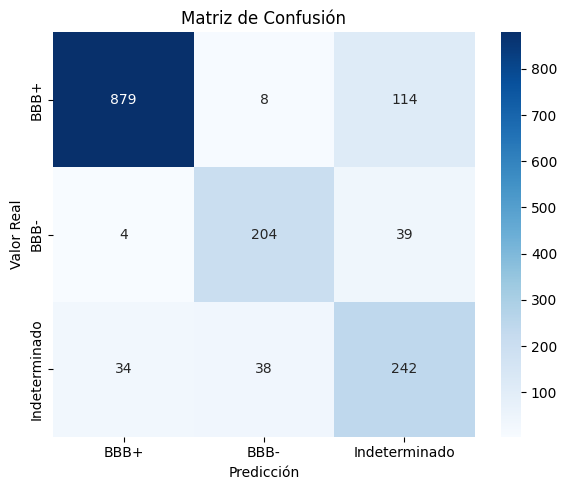


Informe de Clasificación:
               precision    recall  f1-score   support

         BBB+       0.96      0.88      0.92      1001
         BBB-       0.82      0.83      0.82       247
Indeterminado       0.61      0.77      0.68       314

     accuracy                           0.85      1562
    macro avg       0.80      0.82      0.81      1562
 weighted avg       0.87      0.85      0.85      1562



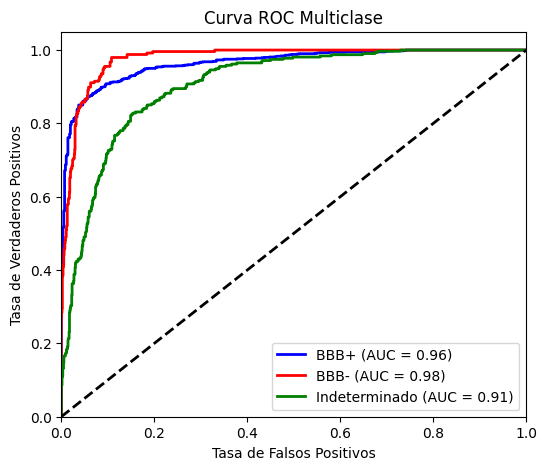

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

"""
Carga y preprocesamiento de datos
Esta sección se encarga de cargar el archivo CSV y preparar los datos para el análisis
"""
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

"""
Funciones de evaluación molecular
Estas funciones evalúan diferentes propiedades de las moléculas basadas en su estructura SMILES
"""
def evaluate_smiles_length(smiles):
    length = len(smiles)
    if length <= 59: return 'BBB+'
    elif length > 85: return 'BBB-'
    else: return 'Indeterminado'

def evaluate_chirality(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return 'Quiral' if len(chiral_centers) > 0 else 'No Quiral'

def evaluate_polarity(mol):
    logp = Descriptors.MolLogP(mol)
    if -4.38 <= logp <= 10.06: return 'BBB+'
    elif logp < -8.90 or logp > 12.61: return 'BBB-'
    else: return 'Indeterminado'

def lipinski_rule(mol):
    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return sum([mw <= 500, logp <= 5, hbd <= 5, hba <= 10])

def classify_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return 'SMILES inválido'
    length_class = evaluate_smiles_length(smiles)
    polarity_class = evaluate_polarity(mol)
    lipinski_score = lipinski_rule(mol)
    if length_class == 'BBB+' and polarity_class == 'BBB+' and lipinski_score >= 3:
        return 'Alta probabilidad BBB+'
    elif length_class == 'BBB-' or polarity_class == 'BBB-' or lipinski_score < 2:
        return 'Alta probabilidad BBB-'
    else:
        return 'Indeterminado'

"""
Aplicación de clasificaciones
Se aplican las funciones de evaluación a cada molécula en el dataset
"""
df['BBB_Class'] = df['SMILES'].apply(classify_molecule)
df['Chirality'] = df['SMILES'].apply(lambda x: evaluate_chirality(Chem.MolFromSmiles(x)))
df['SMILES_Length'] = df['SMILES'].apply(len)
df['Lipinski_Score'] = df['SMILES'].apply(lambda x: lipinski_rule(Chem.MolFromSmiles(x)))

"""
Preparación de datos para CNN
Convierte las moléculas SMILES en fingerprints y combina con otras características
"""
def smiles_to_fingerprint(smiles, size=7806):
    mol = Chem.MolFromSmiles(smiles)
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=size)) if mol else [0] * size

features = ['nHBAcc', 'nHBDon', 'MW', 'TopoPSA', 'LabuteASA', 'SMILES_Length', 'Lipinski_Score']
X_fp = np.array([smiles_to_fingerprint(smile) for smile in df['SMILES']])
X_features = df[features].values
X_combined = np.concatenate([X_fp, X_features], axis=1)

"""
Codificación de la variable objetivo
Convierte las clases BBB en valores numéricos
"""
df['BBB_Class_Numeric'] = df['BBB_Class'].map({
    'Alta probabilidad BBB+': 0, 
    'Alta probabilidad BBB-': 1, 
    'Indeterminado': 2
})
y = to_categorical(df['BBB_Class_Numeric'])

"""
División de datos y aplicación de SMOTE
Divide los datos en conjuntos de entrenamiento y prueba, y aplica SMOTE para balancear las clases
"""
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, np.argmax(y_train, axis=1))
y_train_resampled = to_categorical(y_train_resampled)

"""
Escalado de características
Normaliza las características numéricas
"""
scaler = StandardScaler()
X_train_resampled[:, -len(features):] = scaler.fit_transform(X_train_resampled[:, -len(features):])
X_test[:, -len(features):] = scaler.transform(X_test[:, -len(features):])

"""
Reshape para CNN
Adapta los datos al formato requerido por la CNN
"""
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

"""
Definición del modelo CNN
Crea un modelo de red neuronal convolucional con parámetros ajustables
"""
def create_model(input_shape, filters=8, kernel_size=5, dense_units=16, dropout_rate=0.3, learning_rate=0.0005, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

"""
Implementación de validación cruzada
Utiliza K-Fold para una evaluación más robusta del modelo
"""
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled), 1):
    print(f'Fold {fold}')
    X_train_fold, X_val_fold = X_train_resampled[train_idx], X_train_resampled[val_idx]
    y_train_fold, y_val_fold = y_train_resampled[train_idx], y_train_resampled[val_idx]
    
    model = create_model(input_shape=(X_train_fold.shape[1], 1))
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200, batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores[1])
    print(f'Fold {fold} accuracy: {scores[1]:.4f}')

print(f'Mean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')

"""
Entrenamiento del modelo final
Entrena el modelo final utilizando todo el conjunto de datos de entrenamiento
"""
final_model = create_model(input_shape=(X_train_resampled.shape[1], 1))
final_history = final_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=200, batch_size=64, validation_split=0.01,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

"""
Evaluación del modelo
Evalúa el rendimiento del modelo en el conjunto de prueba
"""
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

"""
Visualización de resultados
Genera y muestra la matriz de confusión y la curva ROC
"""
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BBB+', 'BBB-', 'Indeterminado'], yticklabels=['BBB+', 'BBB-', 'Indeterminado'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

print("\nInforme de Clasificación:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['BBB+', 'BBB-', 'Indeterminado']))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
colors = ['blue', 'red', 'green']
for i, color, label in zip(range(3), colors, ['BBB+', 'BBB-', 'Indeterminado']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.show()

In [1]:
import pandas as pd
from IPython.display import display

# Ruta al archivo CSV
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'

# Cargar el archivo CSV en un DataFrame, usando low_memory=False
df = pd.read_csv(file_path, low_memory=False)

# Mostrar las primeras filas del DataFrame con un formato agradable
display(df.head())

,name,SMILES,logBB,Inchi,LogP,nAcid,nBase,nAromAtom,nAromBond,nAtom,...,SRW10,TSRW10,MW,AMW,WPol,Zagreb1,Zagreb2,mZagreb2,Fingerprint,Fingerprint_array
0,bromoform,BrC(Br)Br,NaN,InChI=1S/CHBr3/c2-1(3)4/h1H,2.4547,0,0,0,0,5,...,6.188264,24.179697,249.762836,49.952567,0,12.0,9.0,1.000000,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[0. 0. 0. ... 0. 0. 0.]
1,brimonidine,Brc1c(NC2=NCCN2)ccc2nccnc12,NaN,InChI=1S/C11H10BrN5/c12-9-7(17-11-15-5-6-16-11...,1.7634,0,3,10,11,27,...,9.736193,63.007560,291.011957,10.778221,24,90.0,106.0,3.750000,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[1. 0. 1. ... 1. 0. 1.]
2,tz-19,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,0.58,InChI=1S/C9H8Br3N3/c10-5-3-6(11)8(7(12)4-5)15-...,3.3452,0,3,6,6,23,...,9.473704,59.989045,394.826834,17.166384,19,76.0,87.0,3.305556,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[0. 0. 0. ... 0. 0. 1.]
3,4205-93-0,Brc1cccc(Br)c1NC1=NCCN1,0.33,InChI=1S/C9H9Br2N3/c10-6-2-1-3-7(11)8(6)14-9-1...,2.5827,0,3,6,6,23,...,9.342333,58.496842,316.916321,13.778970,17,70.0,80.0,3.138889,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[0. 0. 0. ... 0. 0. 1.]
4,methane,C,0.00,InChI=1S/CH4/h1H4,0.6361,0,0,0,0,5,...,0.000000,1.000000,16.031300,3.206260,0,0.0,0.0,0.000000,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# ============= IMPORTACIONES =============
import pandas as pd
import numpy as np
import gc  # Nueva importación para la recolección de basura
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============= CONFIGURACIÓN INICIAL =============
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)

# ============= CARGA DE DATOS =============
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

# ============= CLASE PRINCIPAL =============
class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        
        self._analizar_datos_iniciales()
        print("✅ Preprocesamiento inicial completado")
    
    def _analizar_datos_iniciales(self):
        """Análisis inicial detallado de los datos"""
        print("\n📊 Análisis inicial de datos:")
        print("-" * 50)
        
        tipos_datos = self.df.dtypes.value_counts()
        print("Tipos de datos:")
        display(tipos_datos)
        
        nulos = self.df.isnull().sum()
        nulos_relevantes = nulos[nulos > 0]
        print("\nColumnas con valores nulos:")
        if len(nulos_relevantes) > 0:
            display(nulos_relevantes)
        else:
            print("No hay valores nulos en el dataset")
        
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        stats = self.df[numeric_cols].describe()
        print("\nEstadísticas básicas de columnas numéricas:")
        display(stats.round(2))

    def preparar_datos(self):
        """Preparación de datos para entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        valid_idx = ~X.isnull().any(axis=1)
        X = X[valid_idx]
        y = y[valid_idx]
        
        print(f"Características seleccionadas: {len(features)}")
        print(f"Muestras válidas: {len(X)}")
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        print("\n⚖️ Aplicando SMOTE para balance de clases...")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        print(f"Distribución de clases después de SMOTE:")
        print(pd.Series(y_res).value_counts(normalize=True).round(3) * 100)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros para cada modelo"""
        param_grids = {
            'Random Forest': {
                'estimator': RandomForestClassifier(random_state=42),
                'param_grid': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2'],
                    'class_weight': ['balanced', 'balanced_subsample']
                }
            },
            'Naive Bayes': {
                'estimator': BernoulliNB(),
                'param_grid': {
                    'alpha': [0.1, 0.5, 1.0, 2.0],
                    'fit_prior': [True, False]
                }
            },
            'Gaussian Process': {
                'estimator': GaussianProcessClassifier(random_state=42),
                'param_grid': {
                    'kernel': [1.0 * RBF(l) for l in [0.1, 0.5, 1.0]],
                    'max_iter_predict': [100],
                    'n_restarts_optimizer': [0, 1]
                }
            }
        }
        
        optimized_models = {}
        for name, config in param_grids.items():
            print(f"\n🔄 Optimizando {name}...")
            grid_search = GridSearchCV(
                config['estimator'],
                config['param_grid'],
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            optimized_models[name] = grid_search.best_estimator_
            
            print(f"\nMejores parámetros para {name}:")
            best_params_df = pd.DataFrame([grid_search.best_params_])
            display(best_params_df)
            
            print(f"Mejor score: {grid_search.best_score_:.3f}")
        
        # Liberar memoria después de la optimización
        del grid_search
        gc.collect()  # Forzar liberación de memoria
        
        return optimized_models

    def cross_validate_model(self, model, X, y, n_splits=5):
        """Validación cruzada mejorada con visualización"""
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            # Liberar memoria en cada iteración del fold
            del X_train_fold, X_val_fold, y_train_fold, y_val_fold, y_pred
            gc.collect()

        results_df = pd.DataFrame(metrics)
        results_df.index = [f'Fold {i+1}' for i in range(n_splits)]
        results_df.loc['Media'] = results_df.mean()
        results_df.loc['Std'] = results_df.std()
        
        print("\nResultados de validación cruzada:")
        display(results_df.style.format("{:.3f}").background_gradient(cmap='YlOrRd'))
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def entrenar_y_evaluar_modelos(self):
        """Entrenamiento y evaluación de modelos mejorado"""
        print("\n🚀 Iniciando entrenamiento de modelos...")
        start_time = time.time()
        
        # Preparar los datos
        X_train, X_test, y_train, y_test = self.preparar_datos()
        
        # Optimizar hiperparámetros
        optimized_models = self.optimize_hyperparameters(X_train, y_train)
        
        # Evaluar modelos optimizados
        for name, model in optimized_models.items():
            print(f"\nEvaluando modelo {name}...")
            self.cross_validate_model(model, X_train, y_train)
        
        # Liberar memoria después del entrenamiento
        del optimized_models
        gc.collect()
        
        print(f"\n⏰ Tiempo total de ejecución: {time.time() - start_time:.2f} segundos")

# ============= EJECUCIÓN =============
if __name__ == "__main__":
    preparacion = PreparacionBHE(df)
    preparacion.entrenar_y_evaluar_modelos()


📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807

📊 Análisis inicial de datos:
--------------------------------------------------
Tipos de datos:


float64    417
int64      199
object       5
Name: count, dtype: int64


Columnas con valores nulos:


name     1109
logBB    6749
dtype: int64


Estadísticas básicas de columnas numéricas:


,logBB,LogP,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,ATS0d,ATS1d,ATS2d,ATS3d,ATS4d,ATS5d,ATS6d,ATS7d,ATS8d,ATS0Z,ATS1Z,ATS2Z,ATS3Z,ATS4Z,ATS5Z,ATS6Z,ATS7Z,ATS8Z,ATS0m,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,ATS8m,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,ATS6v,ATS7v,ATS8v,ATS0se,ATS1se,ATS2se,ATS3se,ATS4se,ATS5se,ATS6se,ATS7se,ATS8se,ATS0p,ATS1p,ATS2p,ATS3p,ATS4p,ATS5p,ATS6p,ATS7p,ATS8p,ATS0i,ATS1i,ATS2i,ATS3i,ATS4i,ATS5i,ATS6i,ATS7i,ATS8i,AATS0dv,AATS0d,AATS0Z,AATS0m,AATS0v,AATS0se,AATS0p,AATS0i,ATSC0c,ATSC1c,ATSC2c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC7c,ATSC8c,ATSC0dv,ATSC1dv,ATSC2dv,ATSC3dv,ATSC4dv,ATSC5dv,ATSC6dv,ATSC7dv,ATSC8dv,ATSC0d,ATSC1d,ATSC2d,ATSC3d,ATSC4d,ATSC5d,ATSC6d,ATSC7d,ATSC8d,ATSC0Z,ATSC1Z,ATSC2Z,ATSC3Z,ATSC4Z,ATSC5Z,ATSC6Z,ATSC7Z,ATSC8Z,ATSC0m,ATSC1m,ATSC2m,ATSC3m,ATSC4m,ATSC5m,ATSC6m,ATSC7m,ATSC8m,ATSC0v,ATSC1v,ATSC2v,ATSC3v,ATSC4v,ATSC5v,ATSC6v,ATSC7v,ATSC8v,ATSC0se,ATSC1se,ATSC2se,ATSC3se,ATSC4se,ATSC5se,ATSC6se,ATSC7se,ATSC8se,ATSC0p,ATSC1p,ATSC2p,ATSC3p,ATSC4p,ATSC5p,ATSC6p,ATSC7p,ATSC8p,ATSC0i,ATSC1i,ATSC2i,ATSC3i,ATSC4i,ATSC5i,ATSC6i,ATSC7i,ATSC8i,AATSC0c,AATSC0dv,AATSC0d,AATSC0Z,AATSC0m,AATSC0v,AATSC0se,AATSC0p,AATSC0i,BalabanJ,BertzCT,nBonds,nBondsO,nBondsS,nBondsD,nBondsT,nBondsA,nBondsM,nBondsKS,nBondsKD,RNCG,RPCG,C1SP1,C2SP1,C1SP2,C2SP2,C3SP2,C1SP3,C2SP3,C3SP3,C4SP3,FCSP3,Xch-3d,Xch-4d,Xch-5d,Xch-6d,Xch-7d,Xch-3dv,Xch-4dv,Xch-5dv,Xch-6dv,Xch-7dv,Xc-3d,Xc-4d,Xc-5d,Xc-6d,Xc-3dv,Xc-4dv,Xc-5dv,Xc-6dv,Xpc-4d,Xpc-5d,Xpc-6d,Xpc-4dv,Xpc-5dv,Xpc-6dv,Xp-1d,Xp-2d,Xp-3d,Xp-4d,Xp-5d,Xp-6d,Xp-7d,Xp-1dv,Xp-2dv,Xp-3dv,Xp-4dv,Xp-5dv,Xp-6dv,Xp-7dv,SZ,Sm,Sv,Sse,Sp,Si,MZ,Mm,Mv,Mse,Mp,Mi,NsssB,NsCH3,NdCH2,NssCH2,NtCH,NdsCH,NaaCH,NsssCH,NddC,NtsC,NdssC,NaasC,NaaaC,NssssC,NsNH2,NdNH,NssNH,NaaNH,NtN,NdsN,NaaN,NsssN,NddsN,NaasN,NssssN,NsOH,NdO,NssO,NaaO,NsF,NsSiH3,NdsssP,NsSH,NdS,NssS,NaaS,NdssS,NddssS,NsCl,NsBr,NsI,SsssB,SsCH3,SdCH2,SssCH2,StCH,SdsCH,SaaCH,SsssCH,SddC,StsC,SdssC,SaasC,SaaaC,SssssC,SsNH2,SdNH,SssNH,SaaNH,StN,SdsN,SaaN,SsssN,SddsN,SaasN,SssssN,SsOH,SdO,SssO,SaaO,SsF,SsSiH3,SdsssP,SsSH,SdS,SssS,SaaS,SdssS,SddssS,SsCl,SsBr,SsI,ECIndex,fragCpx,fMF,nHBAcc,nHBDon,IC0,IC1,IC2,IC3,IC4,IC5,TIC0,TIC1,TIC2,TIC3,TIC4,TIC5,CIC0,CIC1,CIC2,CIC3,CIC4,CIC5,MIC0,MIC1,MIC2,MIC3,MIC4,MIC5,ZMIC0,ZMIC1,ZMIC2,ZMIC3,ZMIC4,ZMIC5,Lipinski,GhoseFilter,FilterItLogS,VMcGowan,LabuteASA,PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA10,SlogP_VSA11,EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,MPC2,MPC3,MPC4,MPC5,MPC6,MPC7,MPC8,MPC9,MPC10,TMPC10,piPC1,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,bpol,nRing,n3Ring,n4Ring,n5Ring,n6Ring,n7Ring,n8Ring,n9Ring,n12Ring,nG12Ring,nHRing,n3HRing,n4HRing,n5HRing,n6HRing,n7HRing,n8HRing,n9HRing,n12HRing,nG12HRing,naRing,n5aRing,n6aRing,n7aRing,nG12aRing,naHRing,n5aHRing,n6aHRing,n7aHRing,nG12aHRing,nARing,n3ARing,n4ARing,n5ARing,n6ARing,n7ARing,n8ARing,n9ARing,n12ARing,nG12ARing,nAHRing,n3AHRing,n4AHRing,n5AHRing,n6AHRing,n7AHRing,n8AHRing,n9AHRing,n12AHRing,nG12AHRing,nFRing,n4FRing,n6FRing,n7FRing,n8FRing,n9FRing,n10FRing,n11FRing,n12FRing,nG12FRing,nFHRing,n4FHRing,n6FHRing,n7FHRing,n8FHRing,n9FHRing,n10FHRing,n11FHRing,n12FHRing,nG12FHRing,nFaRing,n9FaRing,n10FaRing,n11FaRing,nG12FaRing,nFaHRing,n9FaHRing,n10FaHRing,n11FaHRing,nG12FaHRing,nFARing,n4FARing,n6FARing,n7FARing,n8FARing,n9FARing,n10FARing,n11FARing,n12FARing,nG12FARing,nFAHRing,n4FAHRing,n6FAHRing,n7FAHRing,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12

✅ Preprocesamiento inicial completado

🚀 Iniciando entrenamiento de modelos...

🔄 Preparando datos...
Características seleccionadas: 615
Muestras válidas: 7807

⚖️ Aplicando SMOTE para balance de clases...
Distribución de clases después de SMOTE:
logBB
0   50.000
1   50.000
Name: proportion, dtype: float64

🔄 Optimizando Random Forest...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Mejores parámetros para Random Forest:


,class_weight,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,balanced_subsample,None,sqrt,1,2,200


Mejor score: 0.969

🔄 Optimizando Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Mejores parámetros para Naive Bayes:


,alpha,fit_prior
0,0.100,True


Mejor score: 0.719

🔄 Optimizando Gaussian Process...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:

# ============= IMPORTACIONES =============
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============= CONFIGURACIÓN INICIAL =============
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)

# ============= CARGA DE DATOS =============
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

# ============= CLASE PRINCIPAL =============
class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        
        self._analizar_datos_iniciales()
        print("✅ Preprocesamiento inicial completado")
    
    def _analizar_datos_iniciales(self):
        """Análisis inicial detallado de los datos"""
        print("\n📊 Análisis inicial de datos:")
        print("-" * 50)
        
        tipos_datos = self.df.dtypes.value_counts()
        print("Tipos de datos:")
        display(tipos_datos)
        
        nulos = self.df.isnull().sum()
        nulos_relevantes = nulos[nulos > 0]
        print("\nColumnas con valores nulos:")
        if len(nulos_relevantes) > 0:
            display(nulos_relevantes)
        else:
            print("No hay valores nulos en el dataset")
        
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        stats = self.df[numeric_cols].describe()
        print("\nEstadísticas básicas de columnas numéricas:")
        display(stats.round(2))

    def preparar_datos(self):
        """Preparación de datos para entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        valid_idx = ~X.isnull().any(axis=1)
        X = X[valid_idx]
        y = y[valid_idx]
        
        print(f"Características seleccionadas: {len(features)}")
        print(f"Muestras válidas: {len(X)}")
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        print("\n⚖️ Aplicando SMOTE para balance de clases...")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        print(f"Distribución de clases después de SMOTE:")
        print(pd.Series(y_res).value_counts(normalize=True).round(3) * 100)
        
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def optimize_hyperparameters(self, X_train, y_train):
        """Optimización de hiperparámetros para cada modelo"""
        param_grids = {
            'Random Forest': {
                'estimator': RandomForestClassifier(random_state=42),
                'param_grid': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2'],
                    'class_weight': ['balanced', 'balanced_subsample']
                }
            },
            'Naive Bayes': {
                'estimator': BernoulliNB(),
                'param_grid': {
                    'alpha': [0.1, 0.5, 1.0, 2.0],
                    'fit_prior': [True, False]
                }
            },
            'Gaussian Process': {
                'estimator': GaussianProcessClassifier(random_state=42),
                'param_grid': {
                    'kernel': [1.0 * RBF(l) for l in [0.1, 0.5, 1.0]],
                    'max_iter_predict': [100],
                    'n_restarts_optimizer': [0, 1]
                }
            }
        }
        
        optimized_models = {}
        for name, config in param_grids.items():
            print(f"\n🔄 Optimizando {name}...")
            grid_search = GridSearchCV(
                config['estimator'],
                config['param_grid'],
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            optimized_models[name] = grid_search.best_estimator_
            
            print(f"\nMejores parámetros para {name}:")
            best_params_df = pd.DataFrame([grid_search.best_params_])
            display(best_params_df)
            
            print(f"Mejor score: {grid_search.best_score_:.3f}")
        
        return optimized_models

    def cross_validate_model(self, model, X, y, n_splits=5):
        """Validación cruzada mejorada con visualización"""
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
        
        results_df = pd.DataFrame(metrics)
        results_df.index = [f'Fold {i+1}' for i in range(n_splits)]
        results_df.loc['Media'] = results_df.mean()
        results_df.loc['Std'] = results_df.std()
        
        print("\nResultados de validación cruzada:")
        display(results_df.style.format("{:.3f}").background_gradient(cmap='YlOrRd'))
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        """Reporte de clasificación formateado"""
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        """Matriz de confusión mejorada con anotaciones"""
        cm = confusion_matrix(y_test, y_pred)
        
        fig = go.Figure(data=go.Heatmap(
            z=cm,
            x=['No BHE', 'BHE'],
            y=['No BHE', 'BHE'],
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 16},
            hoverongaps=False,
            colorscale='Blues'
        ))
        
        fig.update_layout(
            title=f'Matriz de Confusión - {title}',
            xaxis_title="Predicho",
            yaxis_title="Real",
            height=500
        )
        
        fig.show()
        
        tn, fp, fn, tp = cm.ravel()
        metrics_df = pd.DataFrame({
            'Métrica': [
                'Verdaderos Negativos',
                'Falsos Positivos',
                'Falsos Negativos',
                'Verdaderos Positivos',
                'Especificidad',
                'Sensibilidad'
            ],
            'Valor': [
                tn, fp, fn, tp,
                tn/(tn+fp),
                tp/(tp+fn)
            ]
        })
        
        print("\nMétricas detalladas de la matriz de confusión:")
        display(metrics_df.style.format({'Valor': '{:.3f}'}))

    def plot_roc_curves_comparison(self, models_data):
        """Comparación de curvas ROC"""
        plt.figure(figsize=(10, 8))
        
        for model_name, (y_test, y_pred_prob) in models_data.items():
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Línea Base')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
        plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
        plt.title('Comparación de Curvas ROC')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

    def analyze_predictions(self, y_true, y_pred, y_prob, title=""):
        """Análisis detallado de predicciones"""
        confidence_scores = np.max(y_prob, axis=1)
        incorrect_predictions = y_true != y_pred
        
        fig = go.Figure()
        
        fig.add_trace(go.Histogram(
            x=confidence_scores[incorrect_predictions],
            name='Predicciones Incorrectas',
            opacity=0.75
        ))
        
        fig.add_trace(go.Histogram(
            x=confidence_scores[~incorrect_predictions],
            name='Predicciones Correctas',
            opacity=0.75
        ))
        
        fig.update_layout(
            title_text=f'Distribución de Confianza en Predicciones - {title}',
            xaxis_title="Confianza",
            yaxis_title="Frecuencia",
            barmode='overlay'
        )
        
        fig.show()
        
        # Continuación de analyze_predictions
        detailed_metrics = pd.DataFrame({
            'Métrica': [
                'Predicciones correctas',
                'Predicciones incorrectas',
                'Confianza media (correctas)',
                'Confianza media (incorrectas)'
            ],
            'Valor': [
                sum(~incorrect_predictions),
                sum(incorrect_predictions),
                confidence_scores[~incorrect_predictions].mean(),
                confidence_scores[incorrect_predictions].mean()
            ]
        })
        
        print("\nMétricas detalladas de predicciones:")
        display(detailed_metrics.style.format({'Valor': '{:.3f}'}))

    def entrenar_y_evaluar_modelos(self):
        """Entrenamiento y evaluación de modelos mejorado"""
        print("\n🚀 Iniciando entrenamiento de modelos...")
        start_time = time.time()
        
        # Preparar datos
        X_train, X_test, y_train, y_test = self.preparar_datos()
        
        # Optimizar hiperparámetros
        optimized_models = self.optimize_hyperparameters(X_train, y_train)
        
        # Resultados
        results = {}
        roc_data = {}
        
        # Entrenar y evaluar cada modelo
        for name, model in optimized_models.items():
            print(f"\n📊 Evaluando {name}...")
            
            # Validación cruzada
            cv_results = self.cross_validate_model(model, 
                                                 pd.DataFrame(X_train), 
                                                 pd.Series(y_train))
            
            # Entrenamiento final
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test)
            
            # Guardar resultados
            results[name] = self.print_classification_report(y_test, y_pred, name)
            roc_data[name] = (y_test, y_pred_prob[:, 1])
            
            # Visualizaciones
            self.plot_confusion_matrix(y_test, y_pred, name)
            self.plot_feature_importance(model, X_train.columns, name)
            self.analyze_predictions(y_test, y_pred, y_pred_prob, name)
            
            # Guardar modelo
            self.save_model(model, f'modelo_{name.lower().replace(" ", "_")}.joblib')
        
        # Comparación final
        self.plot_roc_curves_comparison(roc_data)
        
        # Métricas finales
        metrics_comparison = pd.DataFrame({
            name: {
                'Accuracy': results[name]['accuracy'],
                'Precision (BHE)': results[name]['1']['precision'],
                'Recall (BHE)': results[name]['1']['recall'],
                'F1-Score (BHE)': results[name]['1']['f1-score']
            }
            for name in optimized_models.keys()
        }).round(3)
        
        print("\n=== COMPARACIÓN FINAL DE MODELOS ===")
        display(metrics_comparison.style
               .background_gradient(cmap='YlOrRd')
               .format("{:.3f}"))
        
        elapsed_time = time.time() - start_time
        print(f"\n⏱️ Tiempo total de ejecución: {elapsed_time:.2f} segundos")
        print("\n✨ Análisis completado con éxito ✨")
        
        return optimized_models, results, roc_data

    @staticmethod
    def save_model(model, filename):
        """Guardar modelo con mensaje de confirmación"""
        joblib.dump(model, filename)
        print(f"✅ Modelo guardado como: {filename}")

    @staticmethod
    def load_model(filename):
        """Cargar modelo con verificación"""
        try:
            model = joblib.load(filename)
            print(f"✅ Modelo cargado exitosamente: {filename}")
            return model
        except Exception as e:
            print(f"❌ Error al cargar el modelo: {str(e)}")
            return None

# ============= EJECUCIÓN PRINCIPAL =============
if __name__ == "__main__":
    print("🎯 Iniciando análisis completo de BHE...")
    modelo_bhe = PreparacionBHE(df)
    models, results, roc_data = modelo_bhe.entrenar_y_evaluar_modelos()

    print("\n📊 Generando reporte final...")
    
    # Guardar resultados en un archivo
    with open('resultados_bhe.txt', 'w') as f:
        f.write("=== RESULTADOS DEL ANÁLISIS BHE ===\n\n")
        for model_name, result in results.items():
            f.write(f"\nModelo: {model_name}\n")
            f.write(f"Accuracy: {result['accuracy']:.3f}\n")
            f.write(f"Precision (BHE): {result['1']['precision']:.3f}\n")
            f.write(f"Recall (BHE): {result['1']['recall']:.3f}\n")
            f.write(f"F1-Score (BHE): {result['1']['f1-score']:.3f}\n")
            f.write("-" * 50 + "\n")
    
    print("✨ Análisis completado y resultados guardados ✨")


📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas
🎯 Iniciando análisis completo de BHE...

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807

📊 Análisis inicial de datos:
--------------------------------------------------
Tipos de datos:


float64    417
int64      199
object       5
Name: count, dtype: int64


Columnas con valores nulos:


name     1109
logBB    6749
dtype: int64


Estadísticas básicas de columnas numéricas:


,logBB,LogP,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,ATS0d,ATS1d,ATS2d,ATS3d,ATS4d,ATS5d,ATS6d,ATS7d,ATS8d,ATS0Z,ATS1Z,ATS2Z,ATS3Z,ATS4Z,ATS5Z,ATS6Z,ATS7Z,ATS8Z,ATS0m,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,ATS8m,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,ATS6v,ATS7v,ATS8v,ATS0se,ATS1se,ATS2se,ATS3se,ATS4se,ATS5se,ATS6se,ATS7se,ATS8se,ATS0p,ATS1p,ATS2p,ATS3p,ATS4p,ATS5p,ATS6p,ATS7p,ATS8p,ATS0i,ATS1i,ATS2i,ATS3i,ATS4i,ATS5i,ATS6i,ATS7i,ATS8i,AATS0dv,AATS0d,AATS0Z,AATS0m,AATS0v,AATS0se,AATS0p,AATS0i,ATSC0c,ATSC1c,ATSC2c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC7c,ATSC8c,ATSC0dv,ATSC1dv,ATSC2dv,ATSC3dv,ATSC4dv,ATSC5dv,ATSC6dv,ATSC7dv,ATSC8dv,ATSC0d,ATSC1d,ATSC2d,ATSC3d,ATSC4d,ATSC5d,ATSC6d,ATSC7d,ATSC8d,ATSC0Z,ATSC1Z,ATSC2Z,ATSC3Z,ATSC4Z,ATSC5Z,ATSC6Z,ATSC7Z,ATSC8Z,ATSC0m,ATSC1m,ATSC2m,ATSC3m,ATSC4m,ATSC5m,ATSC6m,ATSC7m,ATSC8m,ATSC0v,ATSC1v,ATSC2v,ATSC3v,ATSC4v,ATSC5v,ATSC6v,ATSC7v,ATSC8v,ATSC0se,ATSC1se,ATSC2se,ATSC3se,ATSC4se,ATSC5se,ATSC6se,ATSC7se,ATSC8se,ATSC0p,ATSC1p,ATSC2p,ATSC3p,ATSC4p,ATSC5p,ATSC6p,ATSC7p,ATSC8p,ATSC0i,ATSC1i,ATSC2i,ATSC3i,ATSC4i,ATSC5i,ATSC6i,ATSC7i,ATSC8i,AATSC0c,AATSC0dv,AATSC0d,AATSC0Z,AATSC0m,AATSC0v,AATSC0se,AATSC0p,AATSC0i,BalabanJ,BertzCT,nBonds,nBondsO,nBondsS,nBondsD,nBondsT,nBondsA,nBondsM,nBondsKS,nBondsKD,RNCG,RPCG,C1SP1,C2SP1,C1SP2,C2SP2,C3SP2,C1SP3,C2SP3,C3SP3,C4SP3,FCSP3,Xch-3d,Xch-4d,Xch-5d,Xch-6d,Xch-7d,Xch-3dv,Xch-4dv,Xch-5dv,Xch-6dv,Xch-7dv,Xc-3d,Xc-4d,Xc-5d,Xc-6d,Xc-3dv,Xc-4dv,Xc-5dv,Xc-6dv,Xpc-4d,Xpc-5d,Xpc-6d,Xpc-4dv,Xpc-5dv,Xpc-6dv,Xp-1d,Xp-2d,Xp-3d,Xp-4d,Xp-5d,Xp-6d,Xp-7d,Xp-1dv,Xp-2dv,Xp-3dv,Xp-4dv,Xp-5dv,Xp-6dv,Xp-7dv,SZ,Sm,Sv,Sse,Sp,Si,MZ,Mm,Mv,Mse,Mp,Mi,NsssB,NsCH3,NdCH2,NssCH2,NtCH,NdsCH,NaaCH,NsssCH,NddC,NtsC,NdssC,NaasC,NaaaC,NssssC,NsNH2,NdNH,NssNH,NaaNH,NtN,NdsN,NaaN,NsssN,NddsN,NaasN,NssssN,NsOH,NdO,NssO,NaaO,NsF,NsSiH3,NdsssP,NsSH,NdS,NssS,NaaS,NdssS,NddssS,NsCl,NsBr,NsI,SsssB,SsCH3,SdCH2,SssCH2,StCH,SdsCH,SaaCH,SsssCH,SddC,StsC,SdssC,SaasC,SaaaC,SssssC,SsNH2,SdNH,SssNH,SaaNH,StN,SdsN,SaaN,SsssN,SddsN,SaasN,SssssN,SsOH,SdO,SssO,SaaO,SsF,SsSiH3,SdsssP,SsSH,SdS,SssS,SaaS,SdssS,SddssS,SsCl,SsBr,SsI,ECIndex,fragCpx,fMF,nHBAcc,nHBDon,IC0,IC1,IC2,IC3,IC4,IC5,TIC0,TIC1,TIC2,TIC3,TIC4,TIC5,CIC0,CIC1,CIC2,CIC3,CIC4,CIC5,MIC0,MIC1,MIC2,MIC3,MIC4,MIC5,ZMIC0,ZMIC1,ZMIC2,ZMIC3,ZMIC4,ZMIC5,Lipinski,GhoseFilter,FilterItLogS,VMcGowan,LabuteASA,PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA10,SlogP_VSA11,EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,MPC2,MPC3,MPC4,MPC5,MPC6,MPC7,MPC8,MPC9,MPC10,TMPC10,piPC1,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,bpol,nRing,n3Ring,n4Ring,n5Ring,n6Ring,n7Ring,n8Ring,n9Ring,n12Ring,nG12Ring,nHRing,n3HRing,n4HRing,n5HRing,n6HRing,n7HRing,n8HRing,n9HRing,n12HRing,nG12HRing,naRing,n5aRing,n6aRing,n7aRing,nG12aRing,naHRing,n5aHRing,n6aHRing,n7aHRing,nG12aHRing,nARing,n3ARing,n4ARing,n5ARing,n6ARing,n7ARing,n8ARing,n9ARing,n12ARing,nG12ARing,nAHRing,n3AHRing,n4AHRing,n5AHRing,n6AHRing,n7AHRing,n8AHRing,n9AHRing,n12AHRing,nG12AHRing,nFRing,n4FRing,n6FRing,n7FRing,n8FRing,n9FRing,n10FRing,n11FRing,n12FRing,nG12FRing,nFHRing,n4FHRing,n6FHRing,n7FHRing,n8FHRing,n9FHRing,n10FHRing,n11FHRing,n12FHRing,nG12FHRing,nFaRing,n9FaRing,n10FaRing,n11FaRing,nG12FaRing,nFaHRing,n9FaHRing,n10FaHRing,n11FaHRing,nG12FaHRing,nFARing,n4FARing,n6FARing,n7FARing,n8FARing,n9FARing,n10FARing,n11FARing,n12FARing,nG12FARing,nFAHRing,n4FAHRing,n6FAHRing,n7FAHRing,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12

✅ Preprocesamiento inicial completado

🚀 Iniciando entrenamiento de modelos...

🔄 Preparando datos...
Características seleccionadas: 615
Muestras válidas: 7807

⚖️ Aplicando SMOTE para balance de clases...
Distribución de clases después de SMOTE:
logBB
0   50.000
1   50.000
Name: proportion, dtype: float64

🔄 Optimizando Random Forest...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Mejores parámetros para Random Forest:


,class_weight,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,balanced_subsample,None,sqrt,1,2,200


Mejor score: 0.969

🔄 Optimizando Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Mejores parámetros para Naive Bayes:


,alpha,fit_prior
0,0.100,True


Mejor score: 0.719

🔄 Optimizando Gaussian Process...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


* El enfoque diseñado para el análisis de la capacidad de las moléculas para atravesar la barrera hematoencefálica (BHE) combina una serie de pasos sistemáticos y metódicos que aseguran la robustez y la efectividad del modelo. En primer lugar, se realiza una carga inicial de los datos utilizando la biblioteca pandas, donde se realiza un análisis preliminar que incluye la verificación de tipos de datos y la identificación de valores nulos. Este análisis inicial es fundamental para comprender la calidad de los datos y tomar decisiones informadas en las etapas posteriores.

* La clase PreparacionBHE es el núcleo del enfoque, donde se encapsulan todos los métodos necesarios para el preprocesamiento, la selección de características, la validación cruzada y la evaluación de los modelos. Para la selección de características, se utiliza la Eliminación Recursiva de Características (RFE) con un clasificador de Random Forest, lo que permite identificar las variables más relevantes que contribuyen a la predicción del modelo. Adicionalmente, se aplica el muestreo SMOTE para abordar el problema del desbalance en las clases, asegurando que el modelo sea capaz de generalizar mejor.

* En la fase de entrenamiento y evaluación, se implementan múltiples modelos, incluyendo Random Forest, Naive Bayes y un clasificador de Proceso Gaussiano. Cada modelo es entrenado utilizando validación cruzada, lo que garantiza que los resultados sean representativos y no estén sesgados. Las métricas de rendimiento, como precisión, recall y F1-score, son calculadas y presentadas en un informe formateado, lo que facilita la comparación entre los modelos. Las visualizaciones, que incluyen matrices de confusión y curvas ROC, se generan para proporcionar una comprensión visual del rendimiento del modelo. Al finalizar el análisis, los resultados se guardan en un archivo para su posterior revisión y análisis, asegurando que se mantenga un registro detallado del trabajo realizado. En resumen, este enfoque metódico no solo permite obtener resultados precisos, sino que también establece un marco claro y replicable para futuras investigaciones en el área de la química computacional y la farmacología.

📂 Cargando datos...
✅ Datos cargados exitosamente: 7807 filas y 621 columnas
🎯 Iniciando análisis completo de BHE...

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807

📊 Análisis inicial de datos:
--------------------------------------------------
Tipos de datos:
float64    417
int64      199
object       5
Name: count, dtype: int64

Valores nulos por columna:
7858

Estadísticas básicas de columnas numéricas:
         logBB     LogP    nAcid    nBase  nAromAtom  nAromBond    nAtom  \
count  1058.00  7807.00  7807.00  7807.00    7807.00    7807.00  7807.00   
mean     -0.08     2.36     0.21     0.68       7.44       7.57    52.15   
std       0.75     2.20     0.59     0.93       5.95       6.11    24.67   
min      -2.69    -8.90     0.00     0.00       0.00       0.00     1.00   
25%      -0.54     1.20     0.00     0.00       0.00       0.00    38.00   
50%      -0.02     2.55     0.00     1.00       6.00       6.00    49.00   
75%       0.42     3.79     0.00     1

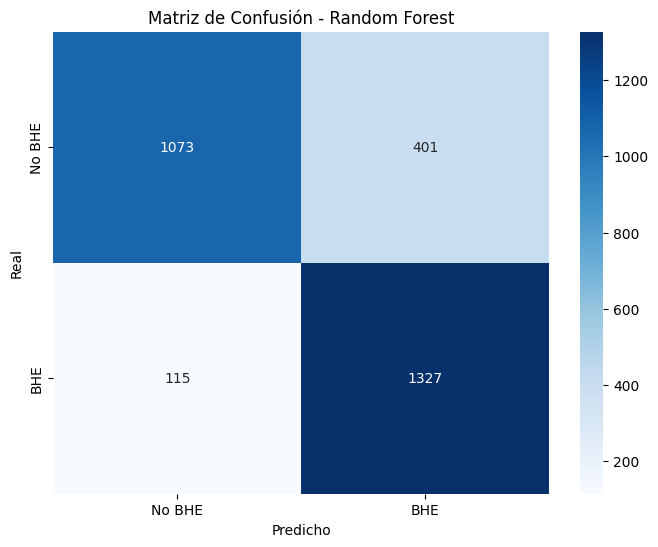

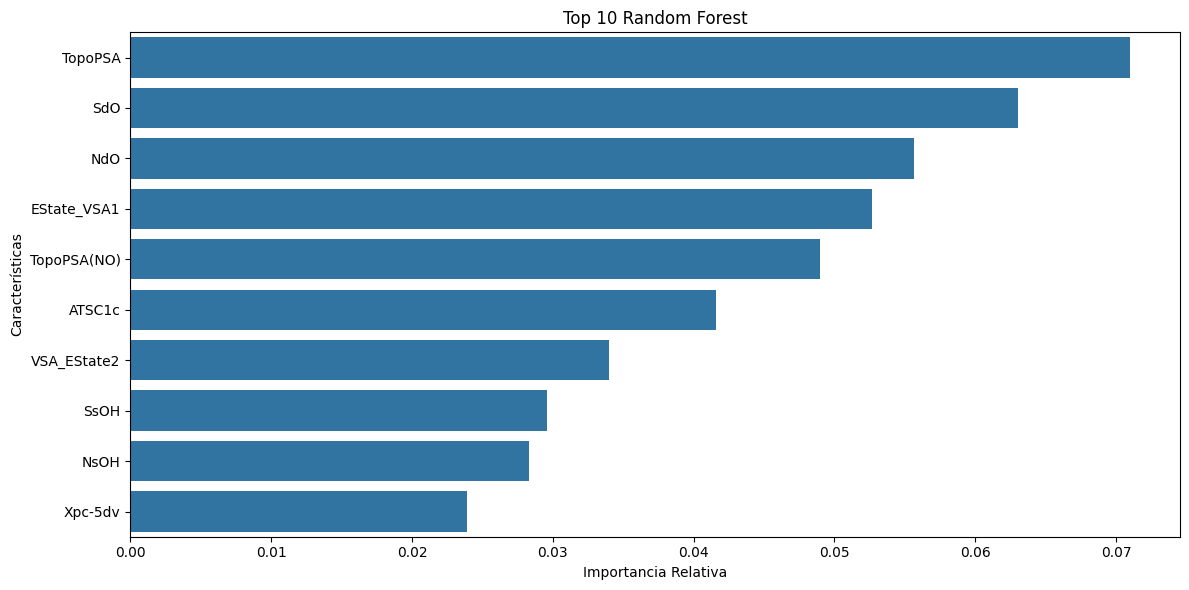

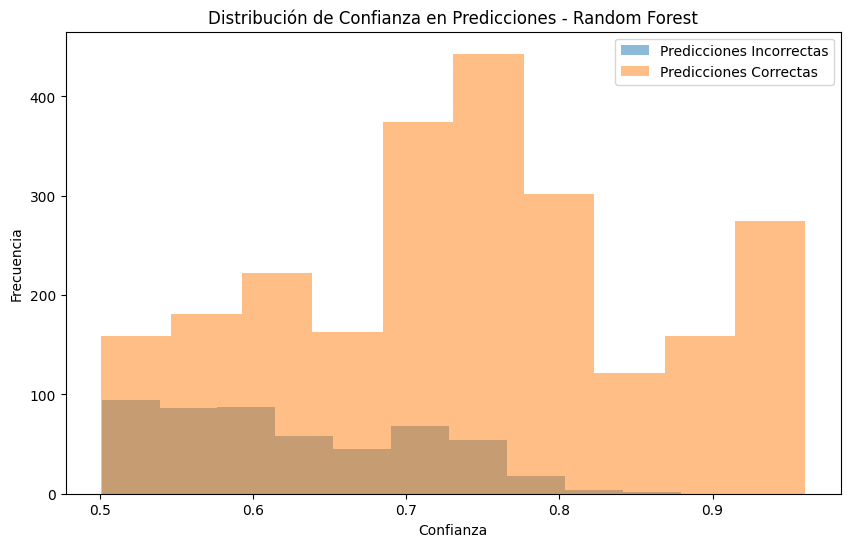

✅ Modelo guardado como: modelo_random_forest.joblib

📊 Entrenando Naive Bayes...

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.701
Precision: 0.636
Recall: 0.978
F1-score: 0.771

Fold 2 resultados:
Accuracy: 0.688
Precision: 0.610
Recall: 0.977
F1-score: 0.751

Fold 3 resultados:
Accuracy: 0.704
Precision: 0.632
Recall: 0.974
F1-score: 0.767

Fold 4 resultados:
Accuracy: 0.717
Precision: 0.646
Recall: 0.980
F1-score: 0.778

Fold 5 resultados:
Accuracy: 0.700
Precision: 0.632
Recall: 0.973
F1-score: 0.766

Resultados validación cruzada para Naive Bayes:
accuracy: 0.702
precision: 0.631
recall: 0.976
f1: 0.767

=== REPORTE DE CLASIFICACIÓN - Naive Bayes ===

Resultados por Clase:
-----------------------------------------------------------------
Clase      Precisión    Recall       F1-Score     Muestras  
-----------------------------------------------------------------
No BHE     0.960        0.411        0.576         1474.0
BHE        0.620        0.983        0.7

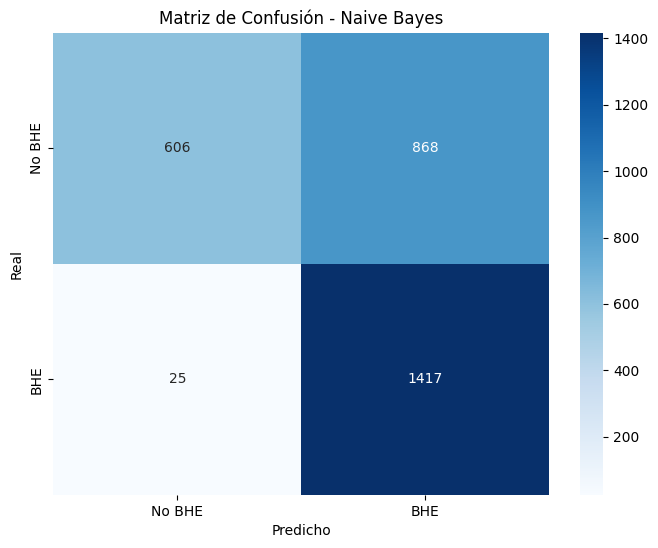

⚠️ Este modelo no proporciona importancia de características


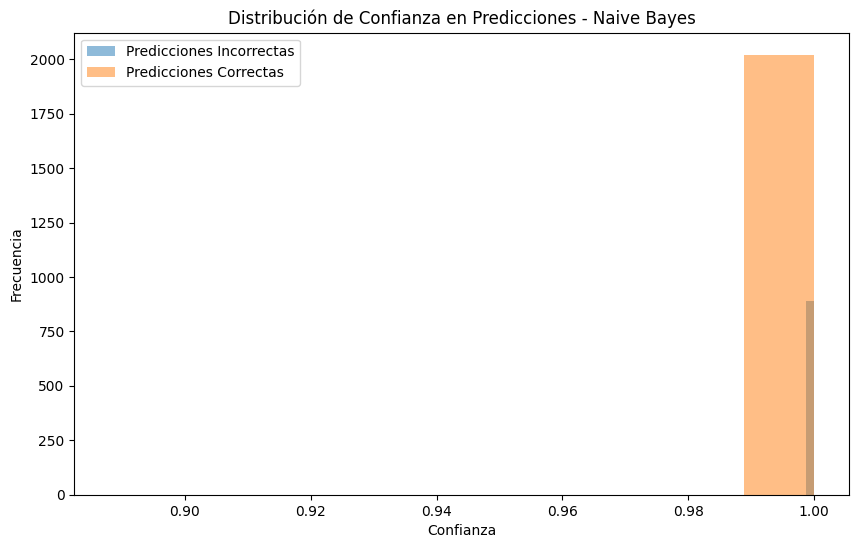

✅ Modelo guardado como: modelo_naive_bayes.joblib

📊 Entrenando Gaussian Process...

🔄 Realizando validación cruzada...

Fold 1 resultados:
Accuracy: 0.973
Precision: 0.961
Recall: 0.987
F1-score: 0.974

Fold 2 resultados:
Accuracy: 0.970
Precision: 0.950
Recall: 0.988
F1-score: 0.969

Fold 3 resultados:
Accuracy: 0.971
Precision: 0.953
Recall: 0.991
F1-score: 0.972

Fold 4 resultados:
Accuracy: 0.965
Precision: 0.944
Recall: 0.990
F1-score: 0.967

Fold 5 resultados:
Accuracy: 0.963
Precision: 0.948
Recall: 0.980
F1-score: 0.964

Resultados validación cruzada para Gaussian Process:
accuracy: 0.968
precision: 0.951
recall: 0.988
f1: 0.969

=== REPORTE DE CLASIFICACIÓN - Gaussian Process ===

Resultados por Clase:
-----------------------------------------------------------------
Clase      Precisión    Recall       F1-Score     Muestras  
-----------------------------------------------------------------
No BHE     0.994        0.955        0.974         1474.0
BHE        0.955        0.9

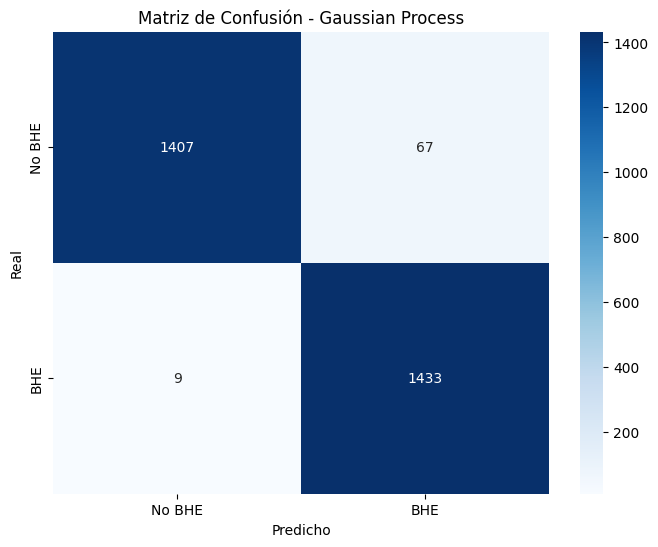

⚠️ Este modelo no proporciona importancia de características


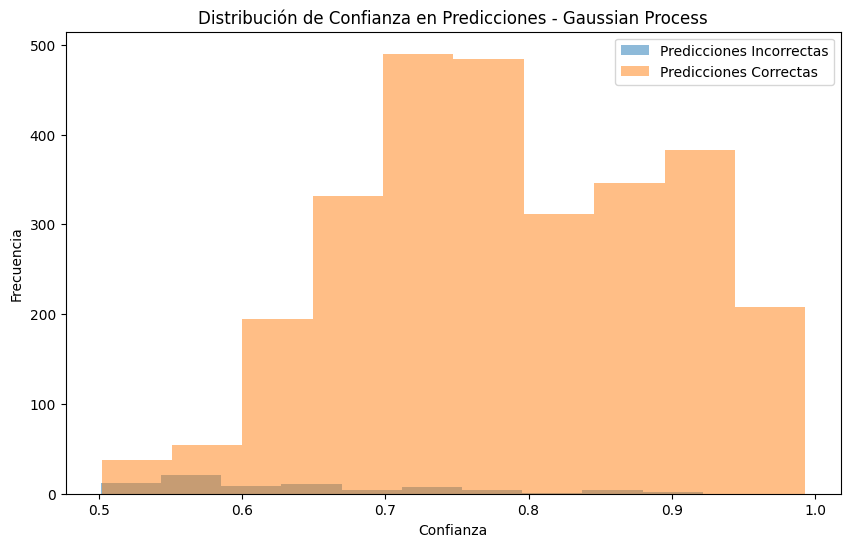

✅ Modelo guardado como: modelo_gaussian_process.joblib


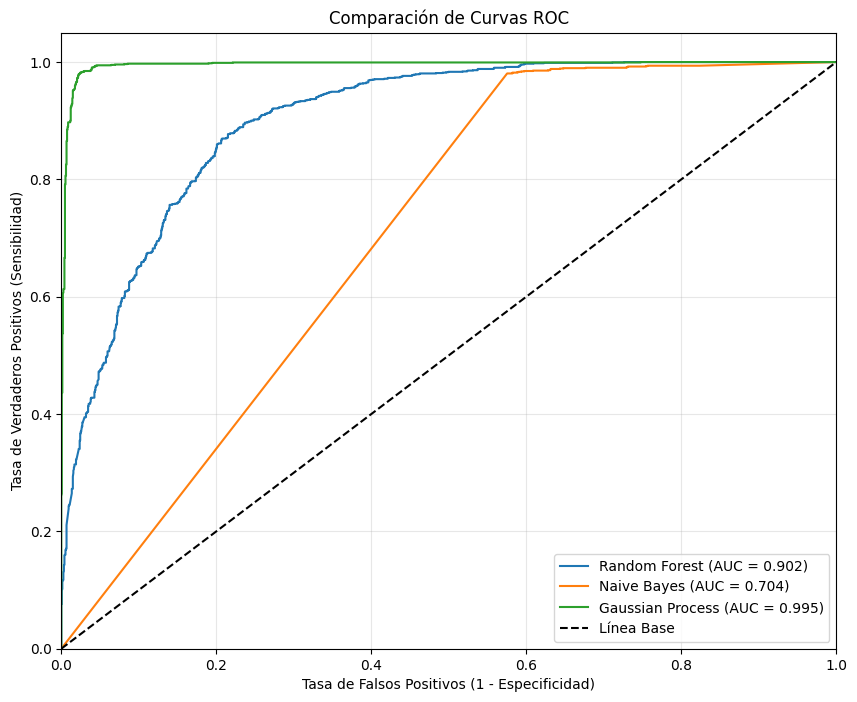


=== COMPARACIÓN FINAL DE MODELOS ===

Comparación de métricas:
                 Random Forest  Naive Bayes  Gaussian Process
Accuracy                 0.823        0.694             0.974
Precision (BHE)          0.768        0.620             0.955
Recall (BHE)             0.920        0.983             0.994
F1-Score (BHE)           0.837        0.760             0.974

⏱️ Tiempo total de ejecución: 16330.95 segundos

✨ Análisis completado con éxito ✨

📊 Generando reporte final...
✨ Análisis completado y resultados guardados ✨


In [14]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from tqdm import tqdm
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Datos cargados exitosamente: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        
        # Análisis inicial de datos
        self._analizar_datos_iniciales()
        print("✅ Preprocesamiento inicial completado")
    
    def _analizar_datos_iniciales(self):
        """Análisis inicial de los datos"""
        print("\n📊 Análisis inicial de datos:")
        print("-" * 50)
        print("Tipos de datos:")
        print(self.df.dtypes.value_counts())
        print("\nValores nulos por columna:")
        print(self.df.isnull().sum().sum())
        
        # Estadísticas básicas de columnas numéricas
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        print("\nEstadísticas básicas de columnas numéricas:")
        print(self.df[numeric_cols].describe().round(2))

    def feature_selection_with_rfe(self, X, y, n_features=30):
        """Selección de características usando RFE"""
        print("\n🔄 Realizando selección de características con RFE...")
        
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=4,
            min_samples_split=20,
            random_state=42
        )
        
        rfe = RFE(estimator=rf, n_features_to_select=n_features)
        rfe = rfe.fit(X, y)
        
        selected_features = X.columns[rfe.support_].tolist()
        print(f"✅ Seleccionadas {len(selected_features)} características")
        print("\nCaracterísticas más importantes:")
        for i, feature in enumerate(selected_features, 1):
            print(f"{i}. {feature}")
        
        return selected_features

    def plot_feature_importance(self, model, features, title="Importancia de Características"):
        """Visualización de importancia de características"""
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=importances.head(10), x='importance', y='feature')
            plt.title(f'Top 10 {title}')
            plt.xlabel('Importancia Relativa')
            plt.ylabel('Características')
            plt.tight_layout()
            plt.show()
            
            return importances
        else:
            print("⚠️ Este modelo no proporciona importancia de características")
            return None

    def cross_validate_model(self, model, X, y, n_splits=5):
        """Validación cruzada del modelo"""
        print("\n🔄 Realizando validación cruzada...")
        
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            metrics['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            metrics['precision'].append(precision_score(y_val_fold, y_pred))
            metrics['recall'].append(recall_score(y_val_fold, y_pred))
            metrics['f1'].append(f1_score(y_val_fold, y_pred))
            
            print(f"\nFold {fold} resultados:")
            print(f"Accuracy: {metrics['accuracy'][-1]:.3f}")
            print(f"Precision: {metrics['precision'][-1]:.3f}")
            print(f"Recall: {metrics['recall'][-1]:.3f}")
            print(f"F1-score: {metrics['f1'][-1]:.3f}")
        
        return {k: np.mean(v) for k, v in metrics.items()}

    def print_classification_report(self, y_test, y_pred, model_name):
        """Reporte de clasificación formateado"""
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_confusion_matrix(self, y_test, y_pred, title=""):
        """Visualización de matriz de confusión"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title(f'Matriz de Confusión - {title}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()

    def plot_roc_curves_comparison(self, models_data):
        """Comparación de curvas ROC"""
        plt.figure(figsize=(10, 8))
        
        for model_name, (y_test, y_pred_prob) in models_data.items():
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Línea Base')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
        plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
        plt.title('Comparación de Curvas ROC')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

    def analyze_predictions(self, y_true, y_pred, y_prob, title=""):
        """Análisis detallado de predicciones"""
        confidence_scores = np.max(y_prob, axis=1)
        incorrect_predictions = y_true != y_pred
        
        plt.figure(figsize=(10, 6))
        plt.hist(confidence_scores[incorrect_predictions], 
                 alpha=0.5, label='Predicciones Incorrectas')
        plt.hist(confidence_scores[~incorrect_predictions], 
                 alpha=0.5, label='Predicciones Correctas')
        plt.title(f'Distribución de Confianza en Predicciones - {title}')
        plt.xlabel('Confianza')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()

    def save_model(self, model, filename):
        """Guardar modelo entrenado"""
        joblib.dump(model, filename)
        print(f"✅ Modelo guardado como: {filename}")

    def load_model(self, filename):
        """Cargar modelo guardado"""
        return joblib.load(filename)

    def preparar_datos(self):
        """Preparación de datos para entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        # Seleccionar características numéricas
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        if 'logBB' in features:
            features = features.drop('logBB')
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        # Aplicar SMOTE
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        # División train/test
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def entrenar_y_evaluar_modelos(self):
        """Entrenamiento y evaluación de modelos"""
        print("\n🚀 Iniciando entrenamiento de modelos...")
        start_time = time.time()
        
        # Preparar datos
        X_train, X_test, y_train, y_test = self.preparar_datos()
        
        # Definir modelos con parámetros más restrictivos
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=50,
                max_depth=3,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            ),
            'Naive Bayes': GaussianNB(),
            'Gaussian Process': GaussianProcessClassifier(
                kernel=1.0 * RBF(length_scale=0.5) + DotProduct(sigma_0=1.0),
                random_state=42,
                max_iter_predict=100
            )
        }
        
        # Resultados
        results = {}
        roc_data = {}
        
        # Entrenar y evaluar cada modelo
        for name, model in models.items():
            print(f"\n📊 Entrenando {name}...")
            
            # Validación cruzada
            cv_results = self.cross_validate_model(model, 
                                                 pd.DataFrame(X_train), 
                                                 pd.Series(y_train))
            print(f"\nResultados validación cruzada para {name}:")
            for metric, value in cv_results.items():
                print(f"{metric}: {value:.3f}")
            
            # Entrenamiento final
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            
            # Guardar resultados
            results[name] = self.print_classification_report(y_test, y_pred, name)
            roc_data[name] = (y_test, y_pred_prob)
            
            # Visualizaciones
            self.plot_confusion_matrix(y_test, y_pred, name)
            self.plot_feature_importance(model, X_train.columns, name)
            self.analyze_predictions(y_test, y_pred, model.predict_proba(X_test), name)
            
            # Guardar modelo
            self.save_model(model, f'modelo_{name.lower().replace(" ", "_")}.joblib')
        
        # Comparar curvas ROC
        self.plot_roc_curves_comparison(roc_data)
        
        # Comparación final de métricas
        print("\n=== COMPARACIÓN FINAL DE MODELOS ===")
        metrics_comparison = pd.DataFrame({
            name: {
                'Accuracy': results[name]['accuracy'],
                'Precision (BHE)': results[name]['1']['precision'],
                'Recall (BHE)': results[name]['1']['recall'],
                'F1-Score (BHE)': results[name]['1']['f1-score']
            }
            for name in models.keys()
        }).round(3)
        
        print("\nComparación de métricas:")
        print(metrics_comparison)
        
        elapsed_time = time.time() - start_time
        print(f"\n⏱️ Tiempo total de ejecución: {elapsed_time:.2f} segundos")
        print("\n✨ Análisis completado con éxito ✨")
        
        return models, results, roc_data

# Ejecutar análisis
if __name__ == "__main__":
    print("🎯 Iniciando análisis completo de BHE...")
    modelo_bhe = PreparacionBHE(df)
    models, results, roc_data = modelo_bhe.entrenar_y_evaluar_modelos()

    print("\n📊 Generando reporte final...")
    
    # Guardar resultados en un archivo
    with open('resultados_bhe.txt', 'w') as f:
        f.write("=== RESULTADOS DEL ANÁLISIS BHE ===\n\n")
        for model_name, result in results.items():
            f.write(f"\nModelo: {model_name}\n")
            f.write(f"Accuracy: {result['accuracy']:.3f}\n")
            f.write(f"Precision (BHE): {result['1']['precision']:.3f}\n")
            f.write(f"Recall (BHE): {result['1']['recall']:.3f}\n")
            f.write(f"F1-Score (BHE): {result['1']['f1-score']:.3f}\n")
            f.write("-" * 50 + "\n")
    
    print("✨ Análisis completado y resultados guardados ✨")

El código define la clase PreparacionBHE, diseñada para entrenar y evaluar modelos de clasificación con el objetivo de predecir la permeabilidad de la barrera hematoencefálica (BHE) de compuestos químicos. Los datos se preprocesan eliminando filas con valores nulos en la columna logBB, escalando las características numéricas y utilizando SMOTE para balancear las clases. Posteriormente, se entrenan tres modelos de clasificación: Random Forest, Naive Bayes y Gaussian Process. Los resultados de cada modelo se analizan utilizando métricas como precisión, recall, F1-score, y las curvas ROC se visualizan para comparar su rendimiento.

La diferencia principal con el código anterior es que se emplea un enfoque de clasificación binaria, utilizando RandomForestClassifier en lugar de RandomForestRegressor. Además, el nuevo código incorpora otros modelos de clasificación (Naive Bayes y Gaussian Process) y se enfoca en balancear las clases usando SMOTE. El análisis de los resultados es más detallado, generando reportes de clasificación, matrices de confusión y comparando múltiples métricas de rendimiento entre los modelos, lo que permite una evaluación más completa de su desempeño.

🎯 Iniciando análisis comparativo de modelos BHE...

🔍 Iniciando análisis de datos...
📊 Número de filas original: 7807
📊 Número de filas después de eliminar nulos de LogBB: 1058
✅ Preprocesamiento inicial completado

🚀 Iniciando entrenamiento de modelos...

🔄 Preparando datos...

📊 Entrenando Random Forest...

=== REPORTE DE CLASIFICACIÓN - Random Forest ===

Resultados por Clase:
-----------------------------------------------------------------
Clase      Precisión    Recall       F1-Score     Muestras  
-----------------------------------------------------------------
No BHE     0.773        0.829        0.800         111.0
BHE        0.804        0.743        0.772         105.0
-----------------------------------------------------------------

Exactitud Global: 0.787
Muestras Totales: 216.0


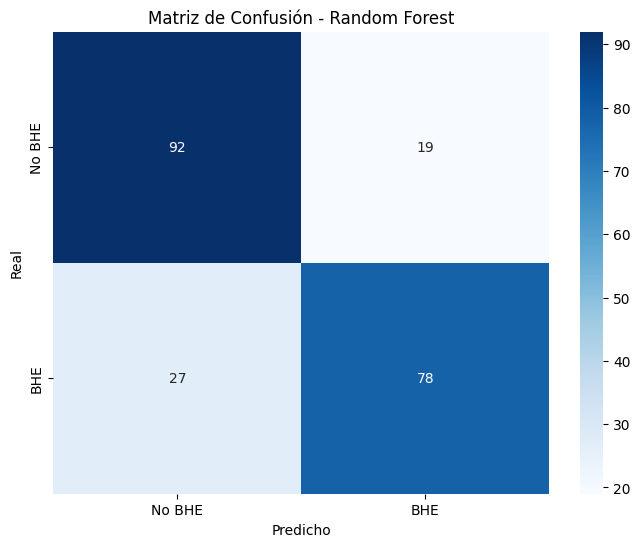


📊 Entrenando Naive Bayes...

=== REPORTE DE CLASIFICACIÓN - Naive Bayes ===

Resultados por Clase:
-----------------------------------------------------------------
Clase      Precisión    Recall       F1-Score     Muestras  
-----------------------------------------------------------------
No BHE     0.750        0.135        0.229         111.0
BHE        0.510        0.952        0.664         105.0
-----------------------------------------------------------------

Exactitud Global: 0.532
Muestras Totales: 216.0


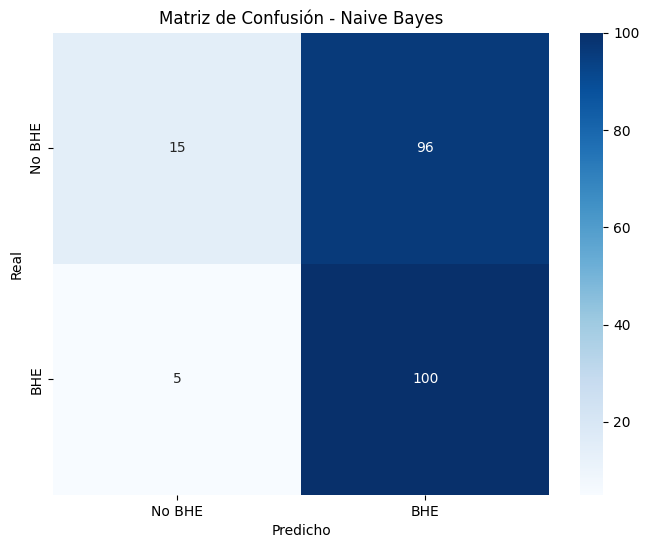


📊 Entrenando Gaussian Process...

=== REPORTE DE CLASIFICACIÓN - Gaussian Process ===

Resultados por Clase:
-----------------------------------------------------------------
Clase      Precisión    Recall       F1-Score     Muestras  
-----------------------------------------------------------------
No BHE     0.817        0.802        0.809         111.0
BHE        0.794        0.810        0.802         105.0
-----------------------------------------------------------------

Exactitud Global: 0.806
Muestras Totales: 216.0


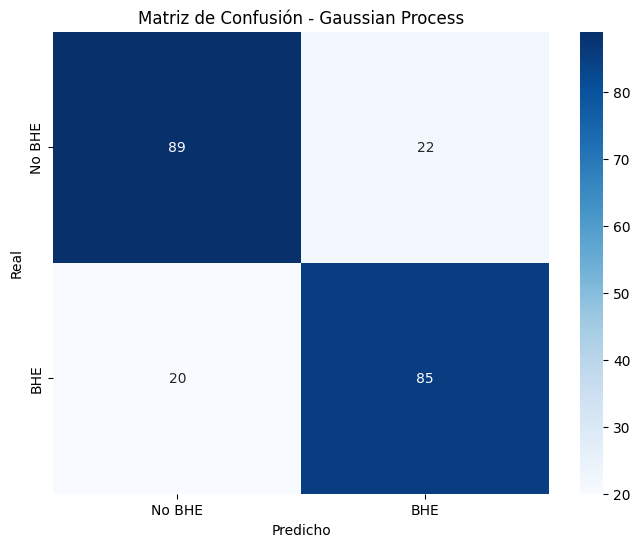

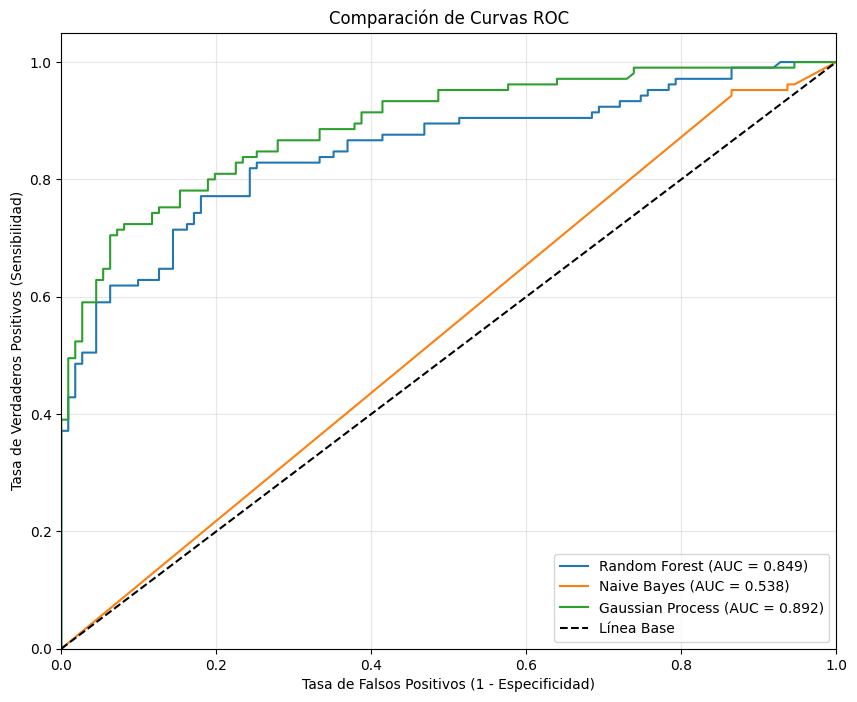


=== COMPARACIÓN DE MODELOS ===

Comparación de métricas:
                 Random Forest  Naive Bayes  Gaussian Process
Accuracy                 0.787        0.532             0.806
Precision (BHE)          0.804        0.510             0.794
Recall (BHE)             0.743        0.952             0.810
F1-Score (BHE)           0.772        0.664             0.802


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from tqdm import tqdm
import time

class PreparacionBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        
        print("\n🔍 Iniciando análisis de datos...")
        print(f"📊 Número de filas original: {len(self.df)}")
        self.df = self.df.dropna(subset=['logBB'])
        print(f"📊 Número de filas después de eliminar nulos de LogBB: {len(self.df)}")
        print("✅ Preprocesamiento inicial completado")
    
    def print_classification_report(self, y_test, y_pred, model_name):
        """Imprime un reporte de clasificación formateado y más interpretable"""
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"\n=== REPORTE DE CLASIFICACIÓN - {model_name} ===")
        print("\nResultados por Clase:")
        print("-" * 65)
        print(f"{'Clase':<10} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
        print("-" * 65)
        print(f"No BHE     {report['0']['precision']:.3f}        {report['0']['recall']:.3f}        {report['0']['f1-score']:.3f}         {report['0']['support']}")
        print(f"BHE        {report['1']['precision']:.3f}        {report['1']['recall']:.3f}        {report['1']['f1-score']:.3f}         {report['1']['support']}")
        print("-" * 65)
        print(f"\nExactitud Global: {report['accuracy']:.3f}")
        print(f"Muestras Totales: {report['0']['support'] + report['1']['support']}")
        
        return report

    def plot_roc_curves_comparison(self, models_data):
        """Grafica curvas ROC comparativas para todos los modelos"""
        plt.figure(figsize=(10, 8))
        
        for model_name, (y_test, y_pred_prob) in models_data.items():
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Línea Base')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
        plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
        plt.title('Comparación de Curvas ROC')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

    def preparar_datos(self):
        """Prepara los datos para el entrenamiento"""
        print("\n🔄 Preparando datos...")
        
        # Seleccionar características numéricas
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB') if 'logBB' in features else features
        
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)  # Binarizar logBB
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        # Aplicar SMOTE
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_scaled, y)
        
        # División train/test
        return train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    def entrenar_y_evaluar_modelos(self):
        """Entrena y evalúa múltiples modelos"""
        print("\n🚀 Iniciando entrenamiento de modelos...")
        
        # Preparar datos
        X_train, X_test, y_train, y_test = self.preparar_datos()
        
        # Definir modelos
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=5,
                min_samples_split=15,
                min_samples_leaf=7,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            ),
            'Naive Bayes': GaussianNB(),
            'Gaussian Process': GaussianProcessClassifier(
                kernel=1.0 * RBF(length_scale=1.0),
                random_state=42,
                max_iter_predict=100
            )
        }
        
        # Resultados para comparación
        results = {}
        roc_data = {}
        
        # Entrenar y evaluar cada modelo
        for name, model in models.items():
            print(f"\n📊 Entrenando {name}...")
            
            # Entrenar modelo
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            
            # Guardar resultados
            results[name] = self.print_classification_report(y_test, y_pred, name)
            roc_data[name] = (y_test, y_pred_prob)
            
            # Matriz de confusión
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['No BHE', 'BHE'],
                       yticklabels=['No BHE', 'BHE'])
            plt.title(f'Matriz de Confusión - {name}')
            plt.ylabel('Real')
            plt.xlabel('Predicho')
            plt.show()
        
        # Comparar curvas ROC
        self.plot_roc_curves_comparison(roc_data)
        
        # Comparación de métricas
        print("\n=== COMPARACIÓN DE MODELOS ===")
        metrics_comparison = pd.DataFrame({
            name: {
                'Accuracy': results[name]['accuracy'],
                'Precision (BHE)': results[name]['1']['precision'],
                'Recall (BHE)': results[name]['1']['recall'],
                'F1-Score (BHE)': results[name]['1']['f1-score']
            }
            for name in models.keys()
        }).round(3)
        
        print("\nComparación de métricas:")
        print(metrics_comparison)
        
        return models, results

# Ejecutar análisis
print("🎯 Iniciando análisis comparativo de modelos BHE...")
modelo_bhe = PreparacionBHE(df)
models, results = modelo_bhe.entrenar_y_evaluar_modelos()